In [1]:
# SET HERE YOUR WORKING PATH to the shared directory SL_Project
path_chiara = '/content/drive/MyDrive/POLIMI/StatLearn/SL_Project'
path_due = '/content/drive/MyDrive/SL_Project'

path = path_chiara 

#Pre-ops
---


In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')

# Insert here the path of the working folder
os.chdir(path) 

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/POLIMI/StatLearn/SL_Project'

In [3]:
pip install mrmr-selection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
import pickle 
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint, uniform
from mrmr import mrmr_classif 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Utils

In [5]:
def compute_metrics(y_train,pred_train,y_test, pred_test):
  train_accuracy = accuracy_score(y_train, pred_train)
  train_f1 = f1_score(y_train, pred_train)
  train_precision = precision_score(y_train, pred_train)
  train_recall = recall_score(y_train, pred_train)
  train_confusion = confusion_matrix(y_train, pred_train)
  train_confusion = train_confusion.astype('float') / train_confusion.sum(axis=1)[:, np.newaxis]

  test_accuracy = accuracy_score(y_test, pred_test)
  test_f1 = f1_score(y_test, pred_test)
  test_precision = precision_score(y_test, pred_test)
  test_recall = recall_score(y_test, pred_test)
  test_confusion = confusion_matrix(y_test, pred_test)
  test_confusion = test_confusion.astype('float') / test_confusion.sum(axis=1)[:, np.newaxis]

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  sns.heatmap(train_confusion, annot=True, linewidths = 0.01, ax = axes[0])
  axes[0].set_title("Confusion Matrix (Training Set)")
  axes[0].set_xlabel("Predicted Labels")
  axes[0].set_ylabel("True Labels")
  sns.heatmap(test_confusion, annot=True, linewidths = 0.01, ax = axes[1])
  axes[1].set_title("Confusion Matrix (Testing Set)")
  axes[1].set_xlabel("Predicted Labels")
  axes[1].set_ylabel("True Labels")
  plt.tight_layout()
  plt.show()

  print("Training Set Metrics:")
  print("Accuracy:", train_accuracy)
  print("F1 Score:", train_f1)
  print("Precision:", train_precision)
  print("Recall:", train_recall)
  print("\nTesting Set Metrics:")
  print("Accuracy:", test_accuracy)
  print("F1 Score:", test_f1)
  print("Precision:", test_precision)
  print("Recall:", test_recall)

In [6]:
def select_nonbinary(df):
  # Select columns with numerical values
  num_cols = df.select_dtypes(include='number')

  # Filter columns with numerical values that are not only 0 and 1
  result_cols = num_cols.apply(lambda col: col.nunique() > 2)

  # Print resulting columns 
  return result_cols.index[result_cols].tolist()

# Load Data
---
Load the prepared dataset from *01.Data_preparation*

In [ ]:
dataset_path_train = path+"/Data/train_2605.csv"  
dataset_path_test = path+"/Data/test_2605.csv" 

In [ ]:
train_set = pd.read_csv(dataset_path_train).drop(['Unnamed: 0'], axis=1)
test_set  = pd.read_csv(dataset_path_test).drop(['Unnamed: 0'], axis=1)
train_set.reset_index(inplace=True)
test_set.reset_index(inplace=True)
test_set.drop(['index'], axis=1,inplace=True)
train_set.drop(['index'], axis=1,inplace=True)
test_set.shape[1] == train_set.shape[1] 

True

In [ ]:
train_set

,Patient_ID,admitted_in_emergency,visit.times,gender,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,...,consciousness_ResponsiveToSound,consciousness_ResponsiveToPain,outcome_during_hospitalization_DischargeAgainstOrder,log.D.dimer,log.brain.natriuretic.peptide,log.eosinophil.count,log.eosinophil.ratio,log.glutamyltranspeptidase,log.high.sensitivity.troponin,log.total.bile.acid
0,772931,1,1,1,37.7,106.0,19.0,105.0,60.0,75.000000,...,0,0,0,0.841567,7.047413,0.000000,0.000000,2.890372,0.063913,1.458615
1,807688,0,1,0,36.4,85.0,19.0,124.0,64.0,84.000000,...,0,0,0,1.350667,7.672632,0.182322,0.025668,4.644391,0.025668,1.327851
2,760934,0,1,1,36.8,106.0,21.0,120.0,80.0,93.333333,...,0,0,0,0.867100,7.161475,0.009950,0.001998,4.574711,0.021761,1.098612
3,744167,0,1,1,36.6,78.0,19.0,145.0,65.0,91.666667,...,0,0,0,1.137833,8.517393,0.009950,0.001998,4.584967,0.165514,1.360977
4,828529,1,1,0,36.5,74.0,19.0,115.0,74.0,87.666667,...,0,0,0,0.955511,8.517393,0.000000,0.000000,3.713572,0.442761,1.974081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,855452,0,1,0,36.0,65.0,20.0,90.0,60.0,70.000000,...,0,0,1,0.482426,6.820595,0.029559,0.007968,3.496508,0.050693,1.629241
1552,870646,1,1,0,36.0,60.0,30.0,171.0,117.0,135.000000,...,0,0,0,0.600754,6.099361,0.198851,0.032467,3.332205,-0.083889,1.360977
1553,738780,0,1,1,36.3,104.0,19.0,136.0,62.0,86.666667,...,0,0,0,0.576613,4.233672,0.000000,0.000000,3.091042,0.018822,1.542304
1554,831820,1,1,0,36.4,80.0,17.0,106.0,64.0,78.000000,...,0,0,0,0.542324,7.742684,0.009950,0.001000,3.847543,0.096219,1.081083


In [ ]:
#remove patients with outcome 2
if 2 in train_set['Outcome'].unique():
  print("Dead patients in train dataset, removing them")
  train_set = train_set[train_set['Outcome'] != 2]

if 2 in test_set['Outcome'].unique():
  print("Dead patients in test dataset, removing them")
  test_set = test_set[test_set['Outcome'] != 2]

In [ ]:
try:
  train_set.drop(['return.to.emergency.department.within.6.months','log.re.admission.time..days.from.admission.','log.time.to.emergency.department.within.6.months'
],axis=1,inplace=True)
  test_set.drop(['return.to.emergency.department.within.6.months','log.re.admission.time..days.from.admission.','log.time.to.emergency.department.within.6.months'
],axis=1,inplace=True)

except: 
  print('nothing to do')

nothing to do


# Feature Selection
----

## Kruskal-Wallis-H-test 
It tests the null hypothesis that the population median of all of the groups are equal. For each variable, we want to test whether its distribution for readmitted subject and not-readmitted subjects is different or not.

In [ ]:
numericals_kruskal = select_nonbinary(train_set)
numericals_kruskal.append('Outcome') 
numericals_kruskal.remove('Patient_ID')
len(numericals_kruskal) 

90

In [ ]:
from scipy.stats import kruskal 

#create dataframe with continuous variables only
X_train_stat_k = train_set[numericals_kruskal].copy() 
X_train_stat_k.shape 

#divide dataframe in two sub-dataframe: one with not-readmitted patients (Outcome = 0) and the other with readmitted ones (Outcome = 1)
outcome0 = X_train_stat_k[X_train_stat_k['Outcome']==0] 
outcome1= X_train_stat_k[X_train_stat_k['Outcome']==1] 

#initialize dictionaries
h_statistics = {}             
p_val = {}                    
count = 0

#for each column computes H-statistics between readmitted and not-readmitted patients
for i in X_train_stat_k.columns: 
    var_group0 = outcome0[i]                                  
    var_group1 = outcome1[i] 
    h_statistics[i], p_val[i] = kruskal(var_group0,var_group1) 
    
    count=count+1 

#extract only those variables with significant p value
significant_variables_k=[] 
for key, value in p_val.items():
  if (value) < 0.05:
    significant_variables_k.append(key)

In [ ]:
print("Variables that show a significant different distribution when outcome is 1 rather than 0 are: ", len(significant_variables_k))
print("These variables are:", significant_variables_k)            

Variables that show a significant different distribution when outcome is 1 rather than 0 are:  37
These variables are: ['pulse', 'systolic.blood.pressure', 'diastolic.blood.pressure', 'map', 'NYHA.cardiac.function.classification', 'moderate.to.severe.chronic.kidney.disease', 'CCI.score', 'fio2', 'creatinine.enzymatic.method', 'urea', 'uric.acid', 'glomerular.filtration.rate', 'cystatin', 'red.blood.cell', 'coefficient.of.variation.of.red.blood.cell.distribution.width', 'standard.deviation.of.red.blood.cell.distribution.width', 'hematocrit', 'basophil.ratio', 'basophil.count', 'hemoglobin', 'neutrophil.ratio', 'international.normalized.ratio', 'activated.partial.thromboplastin.time', 'prothrombin.activity', 'prothrombin.time.ratio', 'carbon.dioxide.binding.capacity', 'potassium', 'sodium', 'glutamic.pyruvic.transaminase', 'cholesterol', 'low.density.lipoprotein.cholesterol', 'dischargeDay', 'log.D.dimer', 'log.eosinophil.count', 'log.eosinophil.ratio', 'log.high.sensitivity.troponin', '

In [ ]:
'Outcome' in significant_variables_k

True

In [ ]:
#drop non-significant variables
num_to_drop = list(set(numericals_kruskal) - set(significant_variables_k))
train_set = train_set.drop(num_to_drop, axis=1) 
test_set = test_set.drop(num_to_drop, axis=1)  
print(train_set.shape, test_set.shape) 

(1556, 99) (390, 99)


In [ ]:
[x for x in test_set.columns if 'Outcome' in x]

['Outcome']

## Standardization
Here we standardize numerical variables

In [ ]:
significant_variables_k.remove('Outcome')
len(significant_variables_k)

36

In [ ]:
train_copy = train_set.copy()
test_copy = test_set.copy()

In [ ]:
independent_variables = train_copy.loc[:,significant_variables_k] 
scaler = StandardScaler().fit(independent_variables) #call a scaler
train_set_scaled = pd.DataFrame(scaler.fit_transform(independent_variables), columns=significant_variables_k)

In [ ]:
pickle.dump(scaler, open('scaler.pkl', 'wb')) 

independent_variables=test_copy.loc[:,significant_variables_k]
loaded_scaler = pickle.load(open('scaler.pkl', 'rb')) 
test_set_scaled = pd.DataFrame(scaler.fit_transform(independent_variables), columns=significant_variables_k)

In [ ]:
test_set_scaled.isna().sum().sum()

0

##Correlation
In this section we visualize correlation among significant variables and remove those that present a value higher than the threshold (0.75)

In [ ]:
corr_matrix = train_set_scaled.corr() 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head(15) 

,pulse,systolic.blood.pressure,diastolic.blood.pressure,map,NYHA.cardiac.function.classification,moderate.to.severe.chronic.kidney.disease,CCI.score,fio2,creatinine.enzymatic.method,urea,...,potassium,sodium,glutamic.pyruvic.transaminase,cholesterol,low.density.lipoprotein.cholesterol,dischargeDay,log.D.dimer,log.eosinophil.count,log.eosinophil.ratio,log.high.sensitivity.troponin
pulse,NaN,0.078582,0.212765,0.166008,0.061084,-0.065763,-0.029859,0.079056,-0.078403,-0.098047,...,-0.079505,-0.010303,0.060980,0.100311,0.099282,-0.024528,0.123218,-0.058454,-0.082421,0.079410
systolic.blood.pressure,NaN,NaN,0.642354,0.890904,-0.077620,-0.020661,0.007419,0.009383,0.028835,-0.166579,...,-0.122715,0.223737,-0.062139,0.191083,0.126065,-0.055139,-0.008154,0.001596,-0.013120,-0.042173
diastolic.blood.pressure,NaN,NaN,NaN,0.918549,-0.091207,-0.095938,-0.064756,-0.015914,-0.078952,-0.188313,...,-0.139574,0.224718,0.003394,0.194310,0.155314,-0.058391,-0.004115,-0.015240,-0.033584,-0.028512
map,NaN,NaN,NaN,NaN,-0.091961,-0.067322,-0.035296,-0.004939,-0.031993,-0.195929,...,-0.144793,0.246358,-0.029145,0.212877,0.156862,-0.062822,-0.007113,-0.007983,-0.026392,-0.037965
NYHA.cardiac.function.classification,NaN,NaN,NaN,NaN,NaN,0.098240,0.137981,0.065492,0.105615,0.161183,...,0.040838,-0.073892,0.067459,-0.025950,-0.024806,0.045716,0.072478,-0.054968,-0.062565,0.116541
moderate.to.severe.chronic.kidney.disease,NaN,NaN,NaN,NaN,NaN,NaN,0.539217,0.005768,0.400460,0.344099,...,0.177390,-0.103207,-0.007592,-0.018647,-0.039286,0.124044,0.040074,0.008682,-0.004737,0.091954
CCI.score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010674,0.177955,0.192967,...,0.135853,-0.091559,0.081992,-0.031879,-0.031658,0.099570,0.053219,-0.003828,-0.004296,0.109062
fio2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077158,0.058894,...,0.034921,-0.066486,0.033866,0.038013,0.021261,0.045013,0.137819,-0.054158,-0.082628,0.164550
creatinine.enzymatic.method,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.658866,...,0.319780,-0.120502,0.048668,-0.008780,-0.019991,0.107540,0.097130,0.041410,0.017170,0.148220
urea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.450621,-0.271700,0.162319,-0.100346,-0.072994,0.117917,0.154956,-0.059161,-0.054682,0.135540


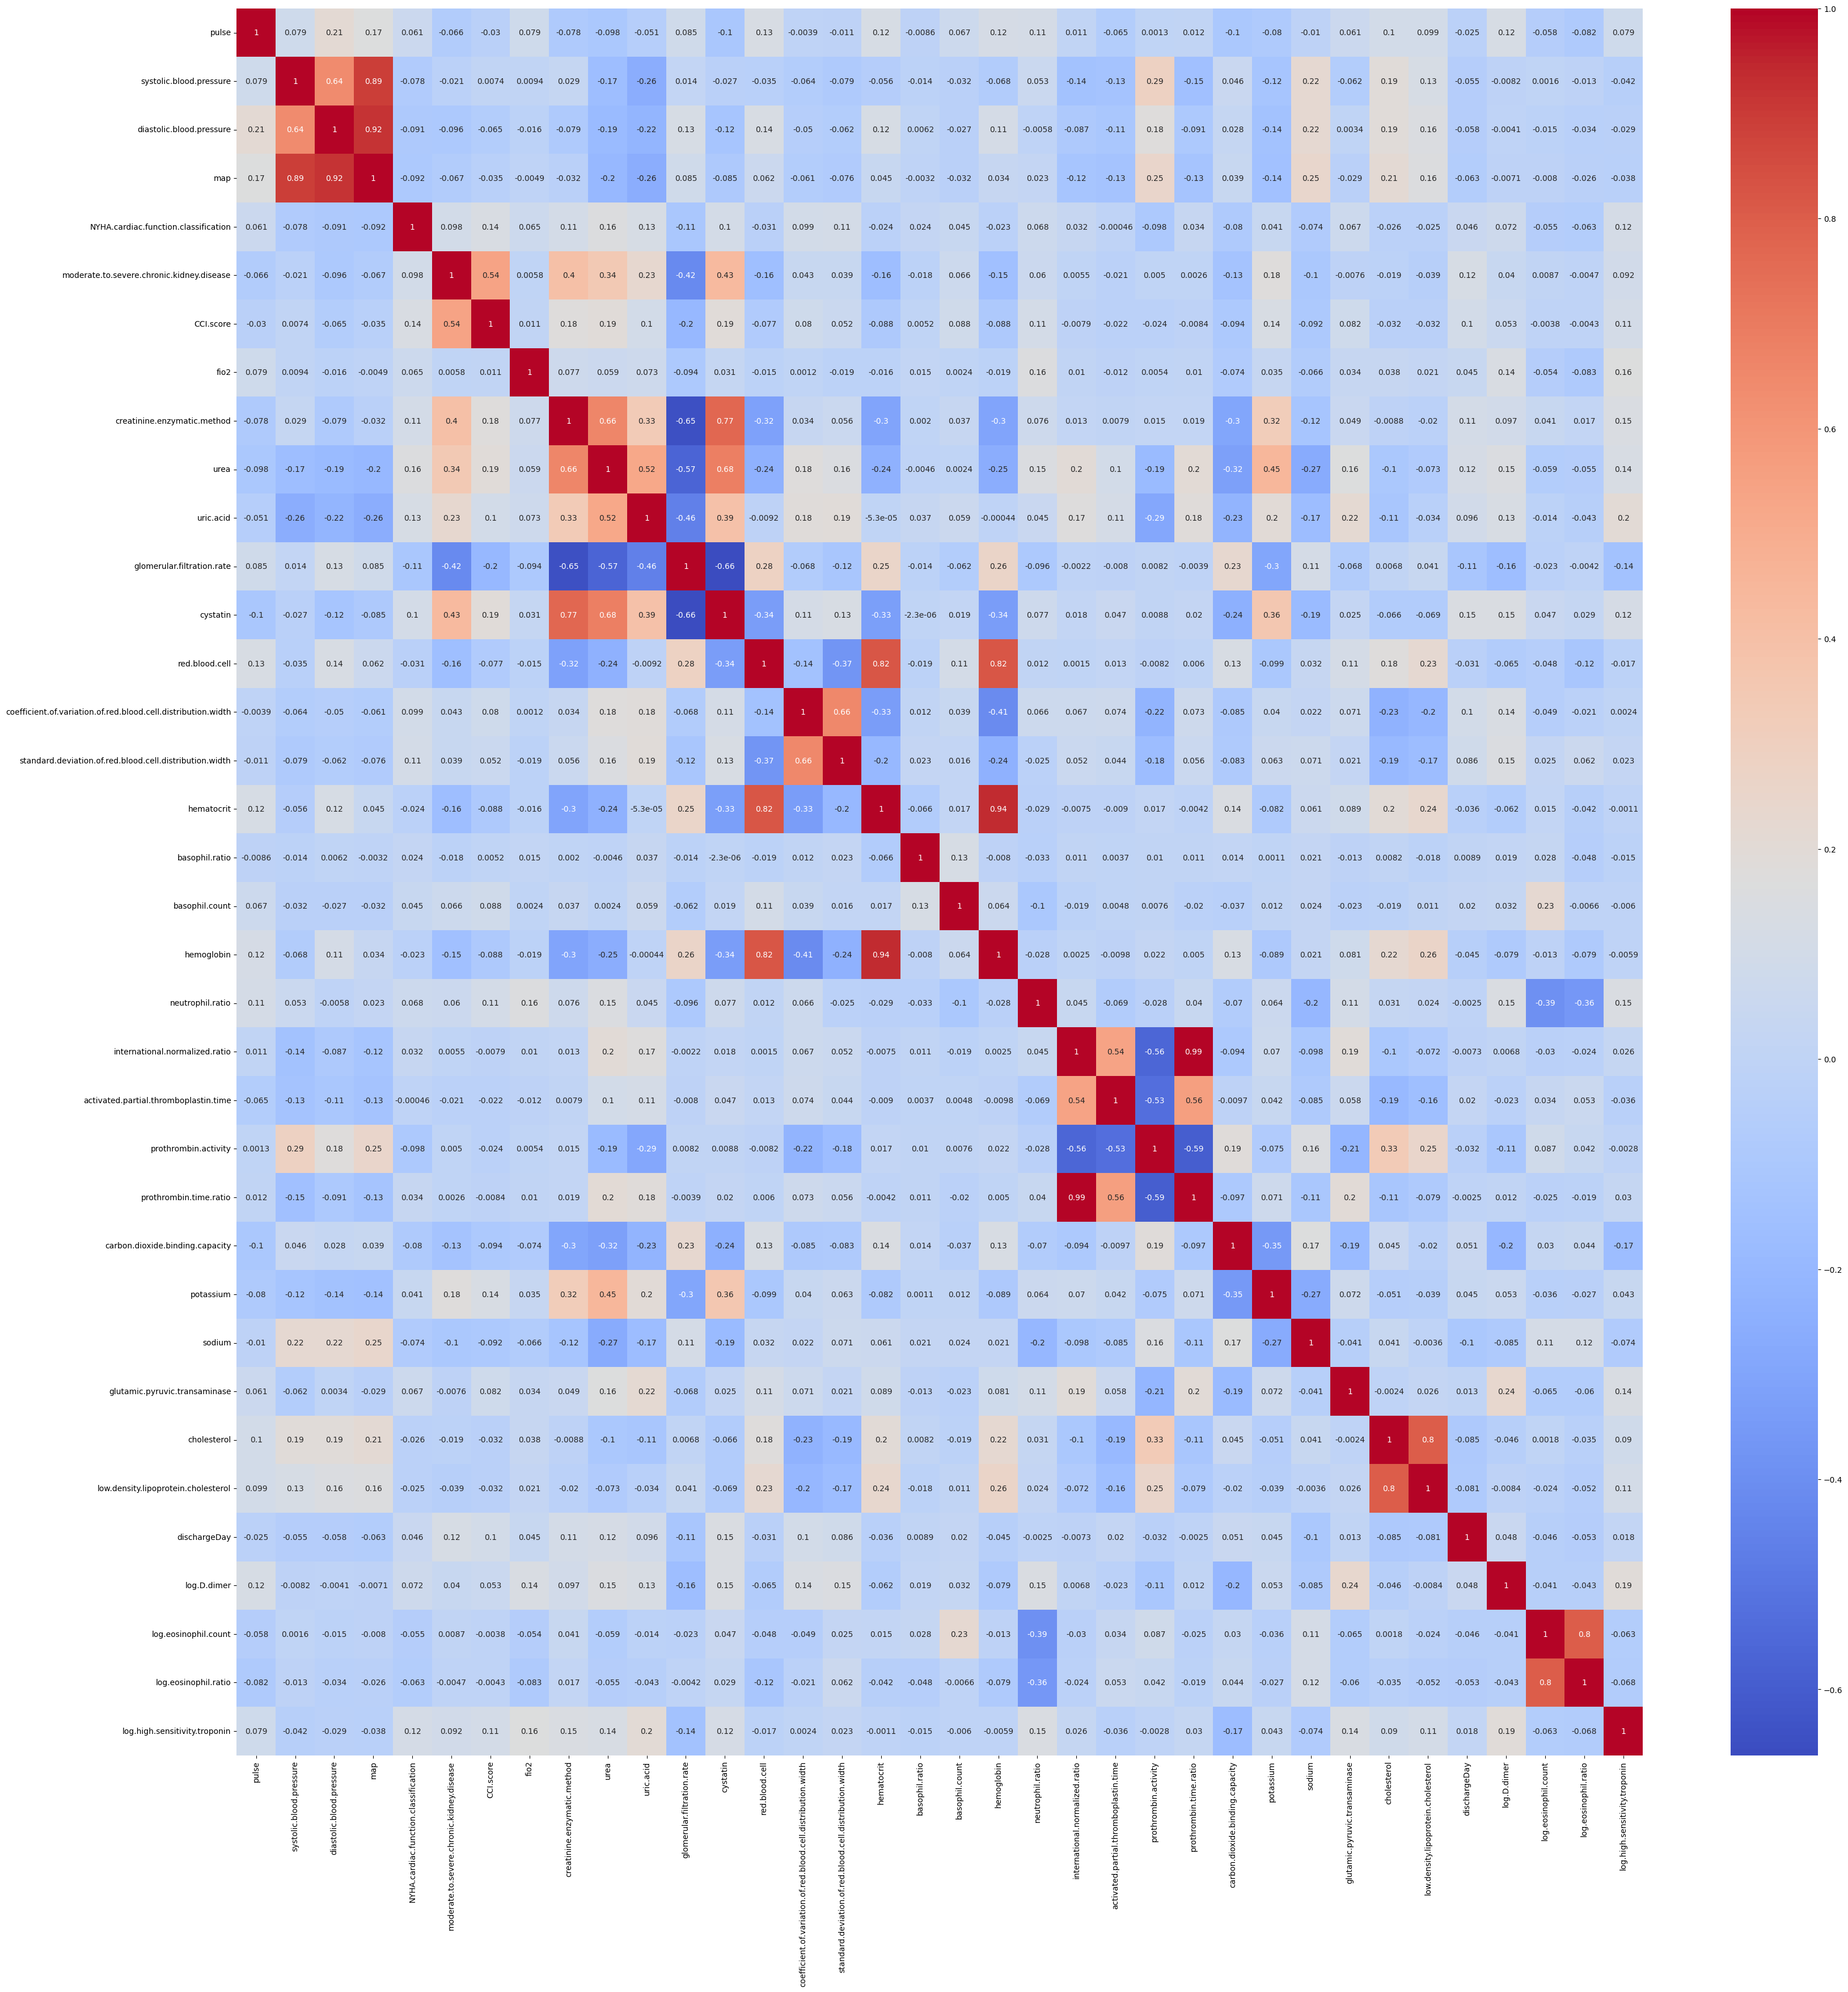

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

In [ ]:
#create dictionary of H values only for those variables turned out to be significant from kruskal
significant_variables_scores = {key: value for key, value in h_statistics.items() if (key) in significant_variables_k}
len(significant_variables_scores)

36

In [ ]:
#change dictionary order of keys according to values in ascending order 
sorted_significant_variables = dict(sorted(significant_variables_scores.items(), key=lambda x:x[1]))
#sorted_significant_variables

In [ ]:
def drop_highly_correlated(variables,df_corr,thr, train_set, test_set):
  for variable in variables:
    if any(abs(df_corr[variable]) > thr):
      df_corr.drop(variable, axis =1, inplace = True)
      df_corr.drop(variable, axis =0, inplace = True)
  
  to_drop = list(set(variables) - set(df_corr.columns))
  train_set = train_set.drop(to_drop, axis=1) 
  test_set = test_set.drop(to_drop, axis=1)  
  
  return train_set, test_set, to_drop, df_corr.columns 

In [ ]:
num_train_set, num_test_set, dropped, uncorrelated = drop_highly_correlated(significant_variables_k, upper.copy(), 0.75, train_set_scaled.copy(), test_set_scaled.copy())
print("dropped columns are:", len(dropped), dropped) 
print("Total columns removed from original dataset:" ,len(train_set.columns) -len(num_train_set.columns) )

dropped columns are: 7 ['hemoglobin', 'log.eosinophil.ratio', 'low.density.lipoprotein.cholesterol', 'prothrombin.time.ratio', 'hematocrit', 'map', 'cystatin']
Total columns removed from original dataset: 70


In [ ]:
num_train_set.isna().sum().sum() 

0

In [ ]:
#show correlation matrix after removal of too correlated variables
corr_matrix = num_train_set.corr() 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head(15) 

,pulse,systolic.blood.pressure,diastolic.blood.pressure,NYHA.cardiac.function.classification,moderate.to.severe.chronic.kidney.disease,CCI.score,fio2,creatinine.enzymatic.method,urea,uric.acid,...,prothrombin.activity,carbon.dioxide.binding.capacity,potassium,sodium,glutamic.pyruvic.transaminase,cholesterol,dischargeDay,log.D.dimer,log.eosinophil.count,log.high.sensitivity.troponin
pulse,NaN,0.078582,0.212765,0.061084,-0.065763,-0.029859,0.079056,-0.078403,-0.098047,-0.050684,...,0.001317,-0.100911,-0.079505,-0.010303,0.060980,0.100311,-0.024528,0.123218,-0.058454,0.079410
systolic.blood.pressure,NaN,NaN,0.642354,-0.077620,-0.020661,0.007419,0.009383,0.028835,-0.166579,-0.255877,...,0.289176,0.046026,-0.122715,0.223737,-0.062139,0.191083,-0.055139,-0.008154,0.001596,-0.042173
diastolic.blood.pressure,NaN,NaN,NaN,-0.091207,-0.095938,-0.064756,-0.015914,-0.078952,-0.188313,-0.219903,...,0.179399,0.027856,-0.139574,0.224718,0.003394,0.194310,-0.058391,-0.004115,-0.015240,-0.028512
NYHA.cardiac.function.classification,NaN,NaN,NaN,NaN,0.098240,0.137981,0.065492,0.105615,0.161183,0.126766,...,-0.097573,-0.079825,0.040838,-0.073892,0.067459,-0.025950,0.045716,0.072478,-0.054968,0.116541
moderate.to.severe.chronic.kidney.disease,NaN,NaN,NaN,NaN,NaN,0.539217,0.005768,0.400460,0.344099,0.231112,...,0.004954,-0.130471,0.177390,-0.103207,-0.007592,-0.018647,0.124044,0.040074,0.008682,0.091954
CCI.score,NaN,NaN,NaN,NaN,NaN,NaN,0.010674,0.177955,0.192967,0.102118,...,-0.024431,-0.094286,0.135853,-0.091559,0.081992,-0.031879,0.099570,0.053219,-0.003828,0.109062
fio2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077158,0.058894,0.072869,...,0.005408,-0.073639,0.034921,-0.066486,0.033866,0.038013,0.045013,0.137819,-0.054158,0.164550
creatinine.enzymatic.method,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.658866,0.332368,...,0.015420,-0.298578,0.319780,-0.120502,0.048668,-0.008780,0.107540,0.097130,0.041410,0.148220
urea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.524378,...,-0.188215,-0.322077,0.450621,-0.271700,0.162319,-0.100346,0.117917,0.154956,-0.059161,0.135540
uric.acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.290006,-0.227218,0.199246,-0.173188,0.218013,-0.111035,0.095969,0.133940,-0.014440,0.202776


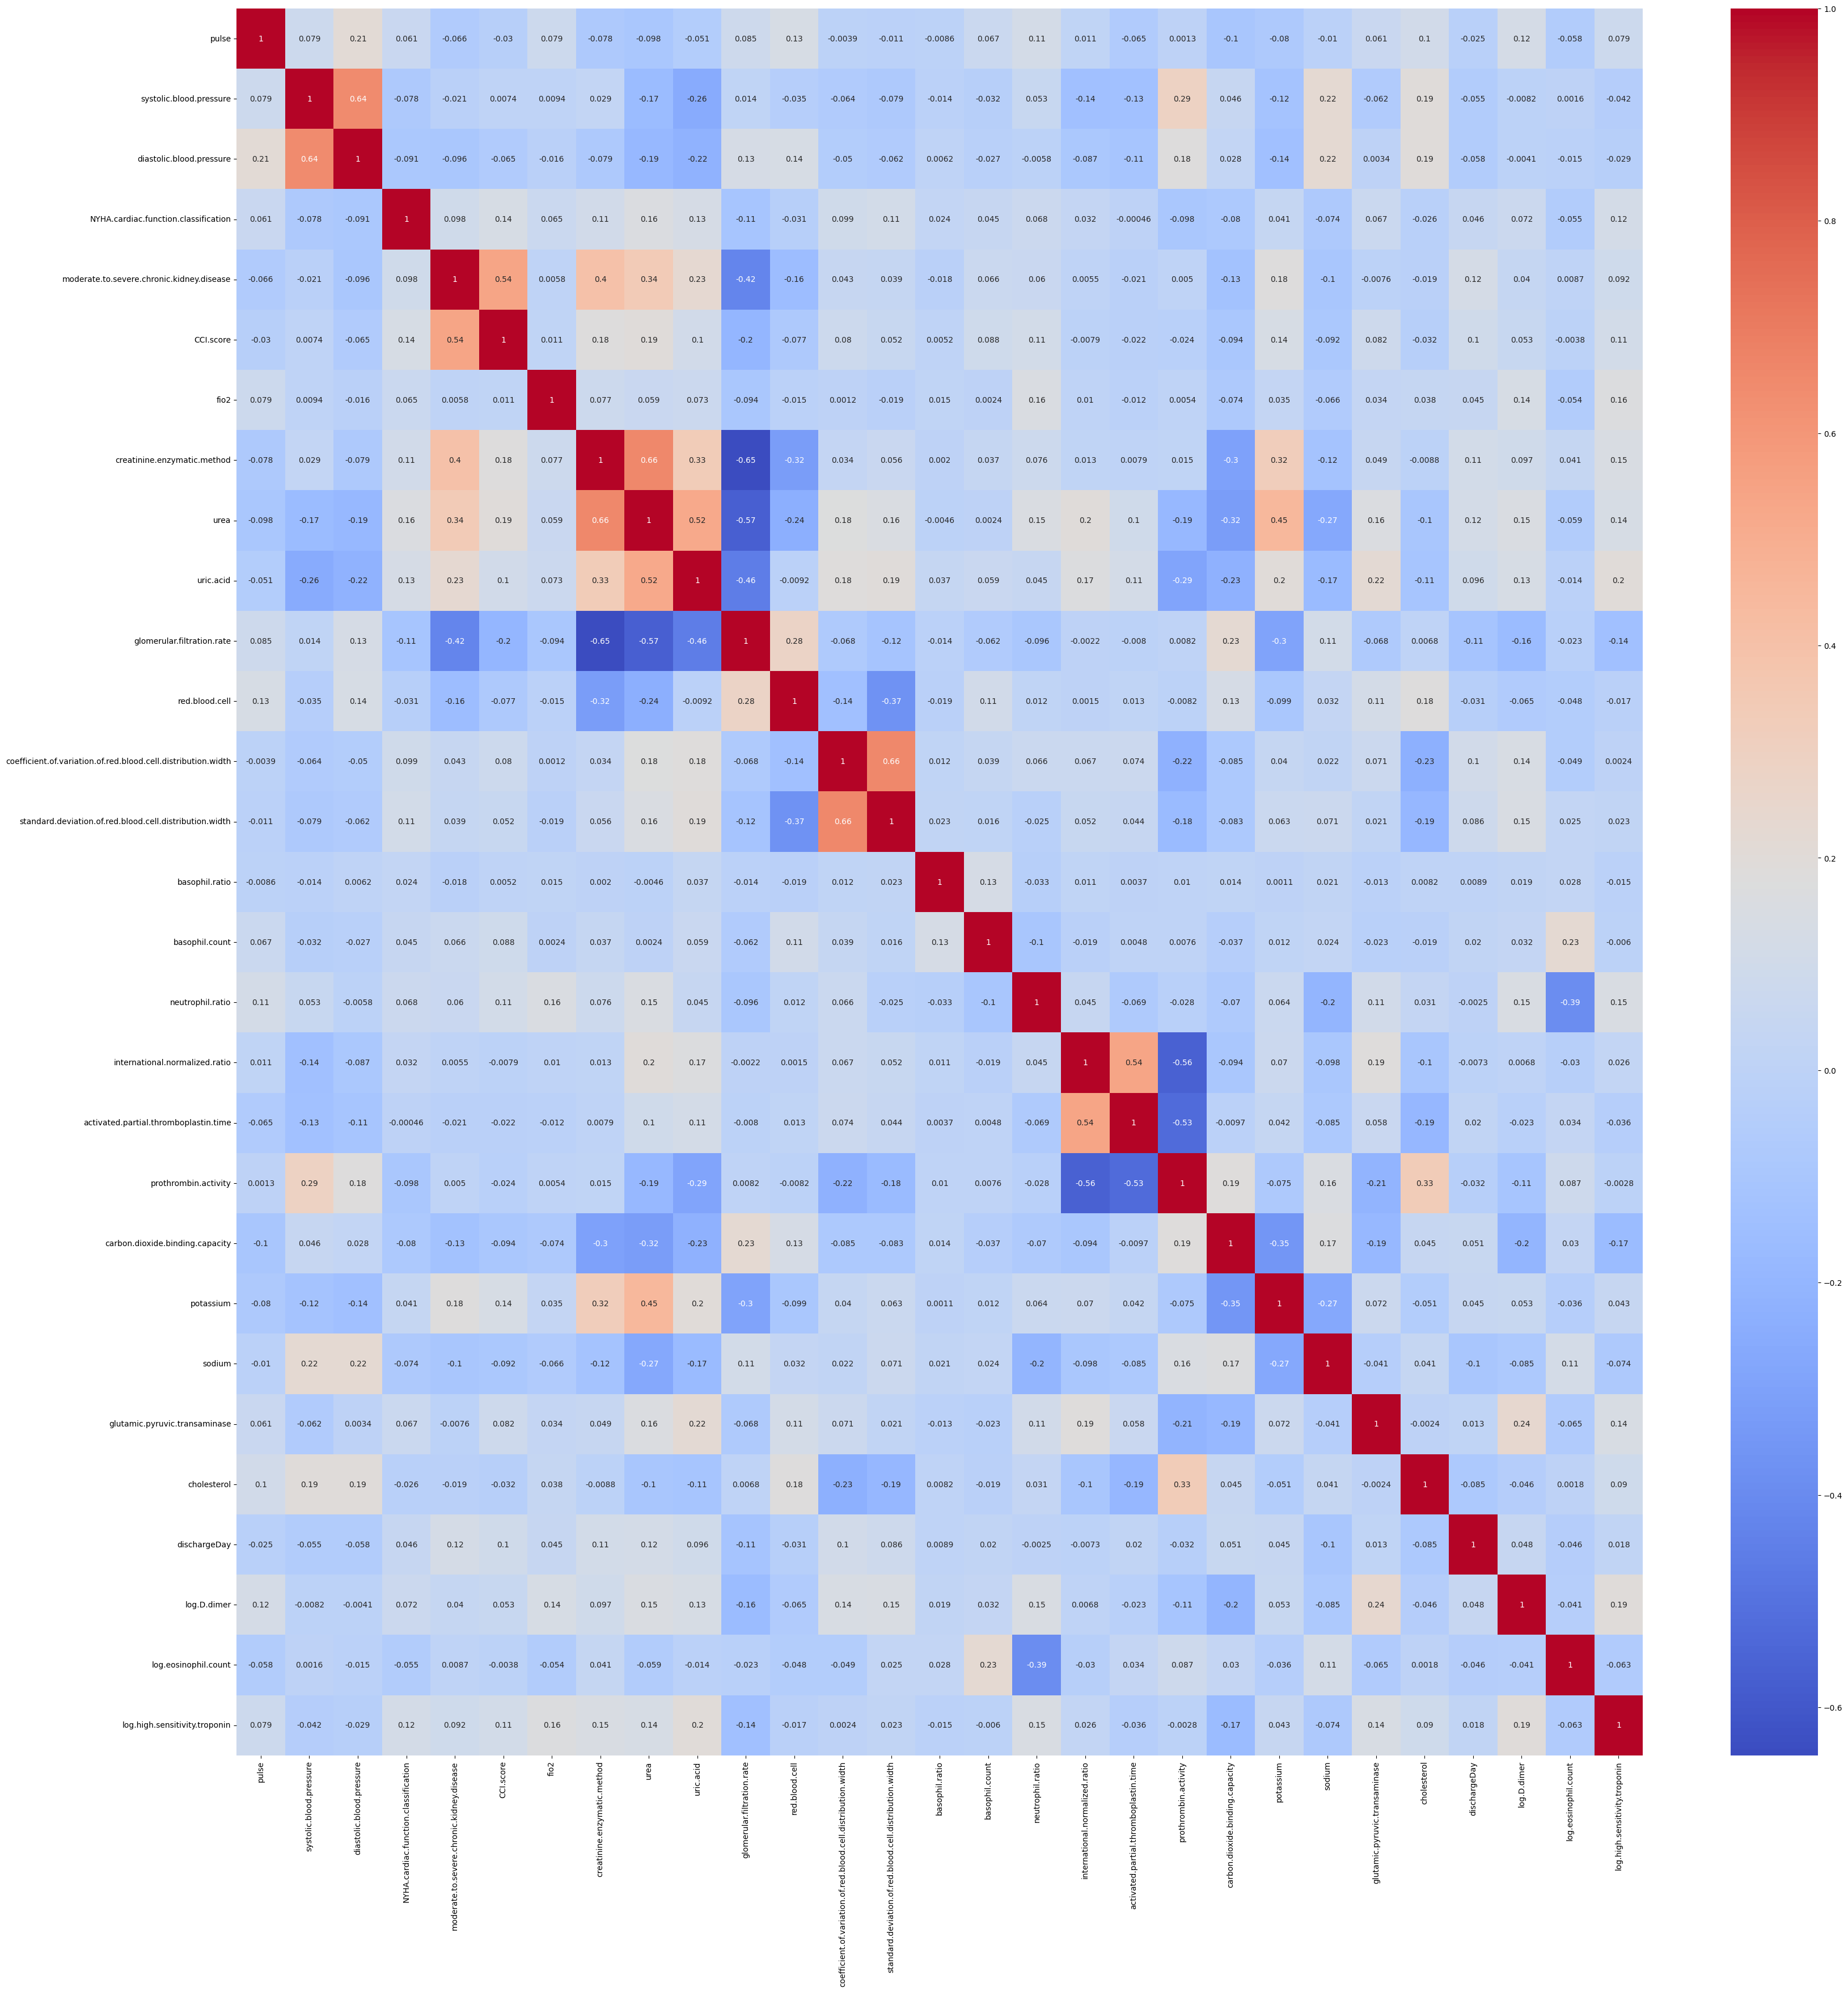

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True) 
plt.show() 

In [ ]:
#update train and test with standardized and selected features
binary = list(set(train_set.columns) - set(select_nonbinary(train_set)))
to_drop = (set(significant_variables_k))-set(uncorrelated)
train_set = train_set.drop(to_drop, axis=1) 
test_set = test_set.drop(to_drop, axis=1) 
test_set.isna().sum().sum()  
train_set[uncorrelated] = num_train_set 
test_set[uncorrelated] = num_test_set 

#final_train_set = pd.concat([train_set[binary], num_train_set], axis = 1) 
#final_test_set = pd.concat([test_set[binary], num_test_set] , axis = 1) 

In [ ]:
print("Both test and train do not contain NaN values:", test_set.isna().sum().sum() == 0 and train_set.isna().sum().sum()  == 0)

Both test and train do not contain NaN values: True


In [ ]:
print("Training shape:", train_set.shape) 
print("Test shape:", test_set.shape) 

Training shape: (1556, 92)
Test shape: (390, 92)


## Chi-squared
In this section we evaluate also categorical variables to be removed due to high correlation with other variables. We compute chi-square statistic and its p-value to test the hypothesis of independence between observed frequencies and contingency table.

In [ ]:
significant_variables_chi2 = [] 

for variable in binary: 
    #Creates contingency table between variable and target (outcome), i.e., combination of 0/1 assumed by the variable and the outcome (0 or 1)
    contingency_table = pd.crosstab(train_set[variable], train_set['Outcome'])
    
    #chi2 test 
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    #save those variables with significative pval
    if p_value < 0.05:
        significant_variables_chi2.append(variable)


In [ ]:
print("Variables that passed chi test are", len(significant_variables_chi2))
print("These variables are:", significant_variables_chi2)         

Variables that passed chi test are 15
These variables are: ['Deslanoside injection', 'type.of.heart.failure_Left', 'Inotropes', 'Milrinone injection', 'occupation_UrbanResident', 'Outcome', 'Hydrochlorothiazide tablet', 'Furosemide tablet', 'Chinese traditional treatments', 'diabetes', 'Meglumine Adenosine Cyclophosphate for injection', 'Torasemide tablet', 'occupation_farmer', 'Furosemide injection', 'Digoxin tablet']


In [ ]:
final_train = train_set.copy() 
final_test = test_set.copy() 
final_train.isna().sum().sum() 

0

In [ ]:
to_drop = set(binary) - set(significant_variables_chi2)
final_train = final_train.drop(to_drop, axis=1) 
final_test = final_test.drop(to_drop, axis=1)  

In [ ]:
print("Final train shape:", final_train.shape)
print("Final test shape:", final_test.shape) 

Final train shape: (1556, 45)
Final test shape: (390, 45)


In [ ]:
train_cat_sign = train_set[significant_variables_chi2] 

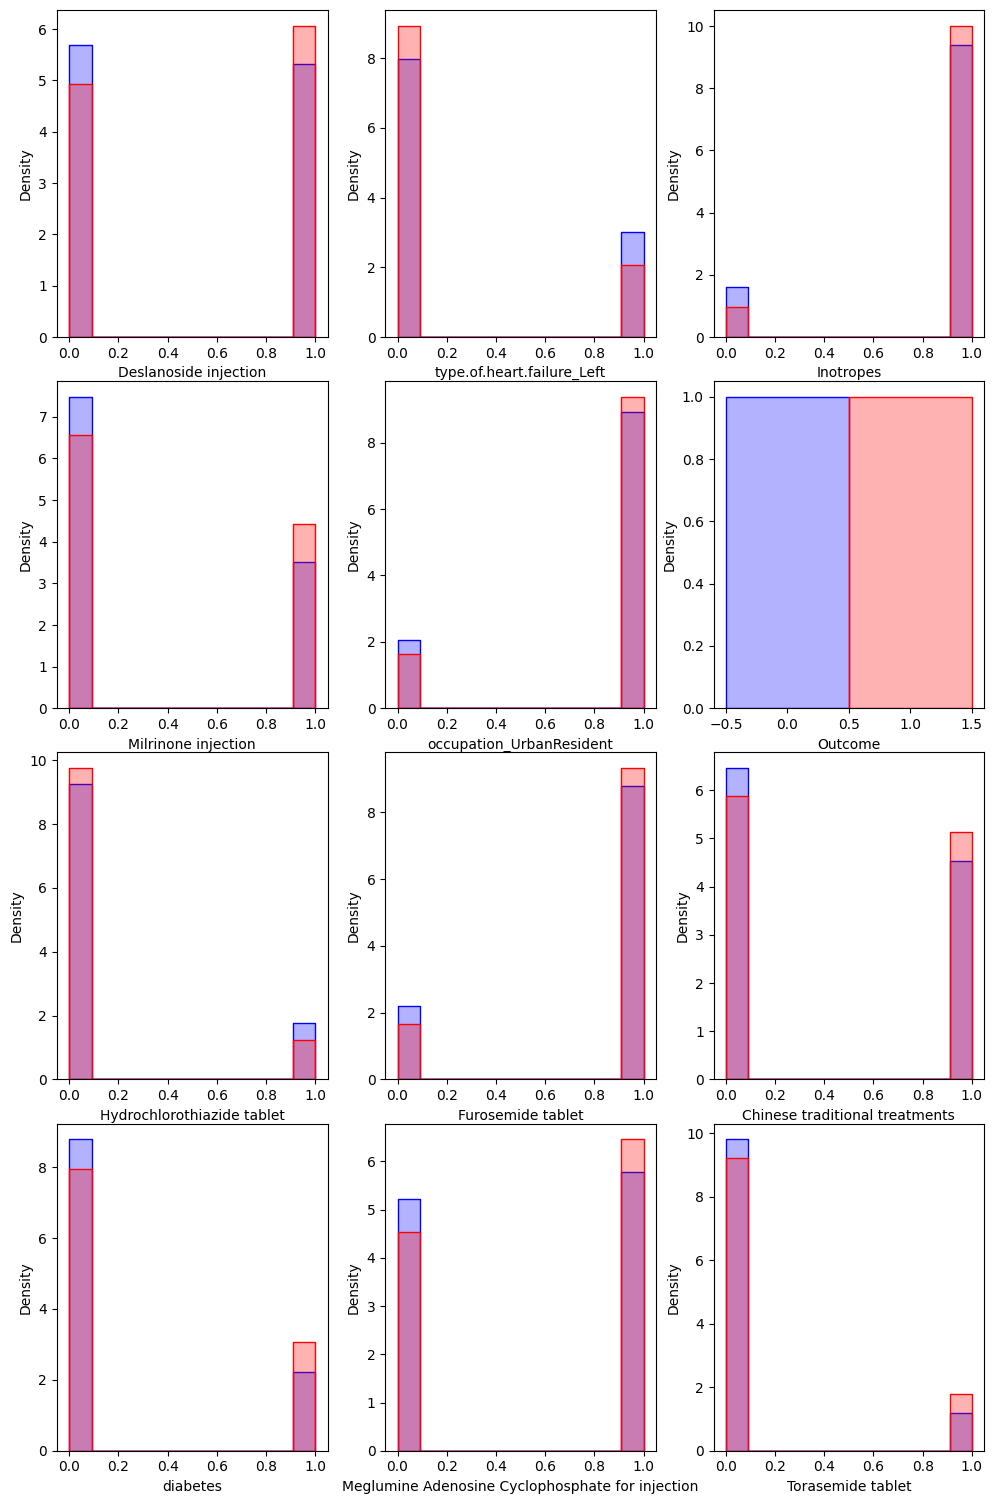

In [ ]:
X0 = train_cat_sign[train_cat_sign['Outcome']==0]
X1 = train_cat_sign[train_cat_sign['Outcome']==1]

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10,15))
fig.tight_layout() 

for i, ax in zip(range(train_cat_sign.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

In [ ]:
final_train.to_csv('Data/train_complete.csv') 
final_test.to_csv('Data/test_complete.csv')   

# Models
---

## Preparing Dataset to the Model

In [ ]:
final_train = pd.read_csv('Data/train_complete.csv').drop(['Unnamed: 0'], axis=1)
final_test = pd.read_csv('Data/test_complete.csv').drop(['Unnamed: 0'], axis=1)

In [ ]:
#check on the shape
print('Train set shape after feature selection:', final_train.shape) 
print('Test set shape after feature selection:', final_test.shape) 
print("Final train does not contain NaN values:", final_train.isna().sum().sum()==0)

Train set shape after feature selection: (1556, 45)
Test set shape after feature selection: (390, 45)
Final train does not contain NaN values: True


In [ ]:
print("Training counts of 0 and 1\n", final_train.groupby('Outcome').size())
print("\n\nTest counts of 0 and 1\n", final_test.groupby('Outcome').size()) 

Training counts of 0 and 1
 Outcome
0    938
1    618
dtype: int64


Test counts of 0 and 1
 Outcome
0    235
1    155
dtype: int64


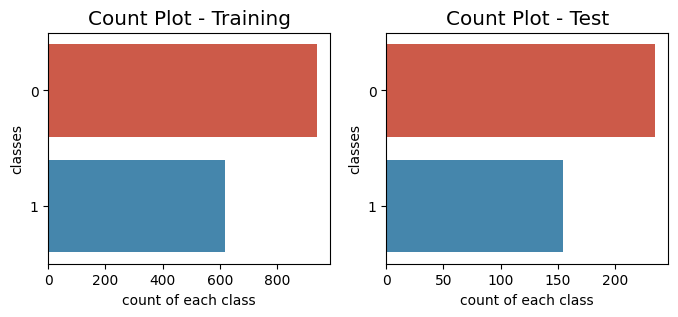

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
plt.style.use('ggplot') 
sns.countplot(y=final_train.Outcome ,data=final_train,ax=axes[0]) 
axes[0].set_xlabel("count of each class")
axes[0].set_ylabel("classes")
axes[0].set_title('Count Plot - Training')
sns.countplot(y=final_test.Outcome ,data=final_test, ax = axes[1]) 
axes[1].set_title('Count Plot - Test')
axes[1].set_xlabel("count of each class")
axes[1].set_ylabel("classes")

plt.show() 

In [ ]:
#Prepare train and labels
y_train = final_train['Outcome']
y_test = final_test['Outcome'] 
X_train = final_train.drop(['Outcome', 'Patient_ID'],axis=1)
X_test = final_test.drop(['Outcome', 'Patient_ID'],axis=1) 

### SMOTE to handle unbalanced classes
Class imbalance can negatively affect the performance of machine learning models, as the model has fewer examples of the minority class to learn from.
To cope with the unbalancement of the classes we will oversample the underrepresented class (readmitted patients). Doing so, we will feed the model with equal observations of the two classes to allow the model to give equal consideration to both classes. 

Here, to avoid ending up with a dataset having synthetic samples constituting more than 30% of the class 1 datapoints, we decided to firstly downsample the majority class (not readmitted, class 0) to make it at most 130% of the underepresented one, and to later oversampling the minority class to equal the majority class. 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE 

#undersampling of class 0
under ={0:788, 1:618}
rus = RandomUnderSampler(sampling_strategy=under)
X_undersampling, y_undersampling = rus.fit_resample(X_train, y_train)

#oversampling class 1
over = {0:788, 1:788} 
smote = SMOTE(sampling_strategy=over)
X_oversampling, y_oversampling = smote.fit_resample(X_undersampling, y_undersampling)

X_train = X_oversampling
y_train = y_oversampling

In [ ]:
'Outcome' not in X_train and 'Outcome' not in X_test 

True

In [ ]:
print(X_train.shape)
print(X_test.shape) 
print((X_train.columns == X_test.columns).all())

(1576, 43)
(390, 43)
True


In [ ]:
X_train.columns 

Index(['pulse', 'systolic.blood.pressure', 'diastolic.blood.pressure',
       'NYHA.cardiac.function.classification', 'diabetes',
       'moderate.to.severe.chronic.kidney.disease', 'CCI.score', 'fio2',
       'creatinine.enzymatic.method', 'urea', 'uric.acid',
       'glomerular.filtration.rate', 'red.blood.cell',
       'coefficient.of.variation.of.red.blood.cell.distribution.width',
       'standard.deviation.of.red.blood.cell.distribution.width',
       'basophil.ratio', 'basophil.count', 'neutrophil.ratio',
       'international.normalized.ratio',
       'activated.partial.thromboplastin.time', 'prothrombin.activity',
       'carbon.dioxide.binding.capacity', 'potassium', 'sodium',
       'glutamic.pyruvic.transaminase', 'cholesterol', 'dischargeDay',
       'Furosemide tablet', 'Meglumine Adenosine Cyclophosphate for injection',
       'Furosemide injection', 'Milrinone injection', 'Deslanoside injection',
       'Torasemide tablet', 'Digoxin tablet', 'Hydrochlorothiazide tablet'

In [ ]:
X_train.to_csv('Data/working_train_2905.csv') 
X_test.to_csv('Data/working_test_2905.csv')   
y_train.to_csv('Data/target_train_2905.csv') 
y_test.to_csv('Data/target_test_2905.csv')   

## Model design

In [51]:
# Loading data
X_train = pd.read_csv('Data/working_train_2905.csv').drop(['Unnamed: 0'], axis=1)
X_test = pd.read_csv('Data/working_test_2905.csv').drop(['Unnamed: 0'], axis=1)

y_train = pd.read_csv('Data/target_train_2905.csv').drop(['Unnamed: 0'], axis=1).values.flatten()
y_test = pd.read_csv('Data/target_test_2905.csv').drop(['Unnamed: 0'], axis=1).values.flatten()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1576, 43)
(390, 43)
(1576,)
(390,)


### Hyperparameter tuning - Random search

In [ ]:
def random_search(classifier, parameters, seed=42): 
  
  cv = StratifiedKFold(n_splits=5)

  random_search = RandomizedSearchCV(classifier, parameters, n_iter=10, scoring='accuracy', cv=cv, random_state=42)

  # Fit the models
  random_search.fit(X_train, y_train)
  
  # Get the best hyperparameters and score
  best_index = random_search.best_index_ 
  best_model = random_search.best_estimator_ 
  best_std = random_search.cv_results_['std_test_score'][best_index]

  y_pred = best_model.predict(X_test) 
  y_pred_train = best_model.predict(X_train) 
    
  return accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred), best_model, best_std 

In [ ]:
acc = {}  #dictionary classifier:score, best_model, best_std

In [ ]:
# MLP 
classifier_mlp = MLPClassifier() 
parameters_mlp = { 
    "hidden_layer_sizes": [(10,5),(20, 12, 4), (40,65,20,16,12), (20,44,15),(10,20)],
    "max_iter": randint(2000, 20000), 
    "alpha": uniform(0.5, 10) 
} 
acc['MLPClassifier'] = random_search(classifier_mlp,parameters_mlp)

In [ ]:
# AdaBoost
classifier_adaboost = AdaBoostClassifier() 
parameters_adaboost = { 
    'n_estimators': randint(30, 500) 
} 
acc['AdaBoostClassifier'] = random_search(classifier_adaboost,parameters_adaboost) 

In [ ]:
# SVC
classifier_svc = SVC(probability=True)
parameters_svc = {
    "kernel": ['linear', 'rbf', 'sigmoid','poly'], 
    "C": uniform(0.001, 3) 
}
acc['SVC'] = random_search(classifier_svc,parameters_svc) 

In [ ]:
# KNN
classifier_knn = KNeighborsClassifier()
parameters_knn = {'n_neighbors': randint(20, 100)}
acc['KNN'] = random_search(classifier_knn,parameters_knn)

# Logistic Regression
classifier_logreg = LogisticRegression() 
parameters_logreg = {"C": [1e-4, 1e-5, 1e-3, 0.01, 0.1, 1, 10], "max_iter": [10000, 5500, 8000, 4000]}
acc['LogisticRegression'] = random_search(classifier_logreg,parameters_logreg)

# Gaussian Naive Bayes
classifier_gnb = GaussianNB()
parameters_gnb = {}
acc['GaussianNB'] = random_search(classifier_gnb,parameters_gnb)

In [ ]:
# Decision Tree
classifier_decision_tree = DecisionTreeClassifier()
parameters_decision_tree = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20, 8, 5],
    'min_samples_split': [10, 30, 50, 80],
    'min_samples_leaf': [10, 20, 14, 8]
} 
acc['DecisionTreeClassifier'] = random_search(classifier_decision_tree,parameters_decision_tree)

# Linear Discriminant Analysis (LDA)
classifier_lda = LinearDiscriminantAnalysis()
parameters_lda = {}
acc['LinearDiscriminantAnalysis'] = random_search(classifier_lda,parameters_lda)

# Quadratic Discriminant Analysis (QDA)
classifier_qda = QuadraticDiscriminantAnalysis()
parameters_qda = {} 
acc['QuadraticDiscriminantAnalysis'] = random_search(classifier_qda,parameters_qda)

In [ ]:
#RandomForest
classifier_rf= RandomForestClassifier() 
parameters_rf = {'n_estimators' : [10,30,100,200,500,600,650], 
    'criterion' : ['entropy', 'gini'], 
              'max_depth': [4,5,6,8,7], 
              'min_samples_split': [5,10,20,8,67,88,32,95], 
              'min_samples_leaf': [10,20,14,8,50,100,70,35]} 
acc['RandomForestClassifier'] = random_search(classifier_rf,parameters_rf) 

In [ ]:
with open('Hyperparameters/random_search.pkl', 'wb') as file:
  pickle.dump(acc,file)

In [ ]:
acc_path = 'Hyperparameters/random_search.pkl'
with open(acc_path, 'rb') as file:  acc = pickle.load(file)

res = pd.DataFrame(acc) 
res.index = ['Accuracy Train', 'Accuracy Test','Parameters','Std over validation'] 
best_models = res.sort_values(by=['Accuracy Test'], axis = 1) 
best_models = best_models.loc[['Parameters','Accuracy Test'],::-1]
best_models.to_csv('Hyperparameters/random_search.csv') 
best_models

,SVC,LinearDiscriminantAnalysis,LogisticRegression,RandomForestClassifier,AdaBoostClassifier,MLPClassifier,GaussianNB,DecisionTreeClassifier,QuadraticDiscriminantAnalysis,KNN
Parameters,"SVC(C=2.498327922401265, probability=True)",LinearDiscriminantAnalysis(),"LogisticRegression(C=0.1, max_iter=5500)","(DecisionTreeClassifier(max_depth=8, max_featu...","(DecisionTreeClassifier(max_depth=1, random_st...","MLPClassifier(alpha=1.9286681792194078, hidden...",GaussianNB(),"DecisionTreeClassifier(criterion='entropy', ma...",QuadraticDiscriminantAnalysis(),KNeighborsClassifier(n_neighbors=22)
Accuracy Test,0.630769,0.625641,0.625641,0.605128,0.587179,0.576923,0.564103,0.561538,0.546154,0.512821


### Hyperparameter tuning - GridSearch

In [ ]:
def hyperp_search_GridSearch(classifier, parameters): #definition of a function used to GridSearch and metrics
    cv = StratifiedKFold(n_splits=5) 
    gs = GridSearchCV(classifier, parameters, cv=cv, scoring = 'accuracy', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train) 
    best_index = gs.best_index_ 
    best_std = gs.cv_results_['std_test_score'][best_index]  
    val_accuracy = gs.cv_results_['mean_test_score'][best_index]
    best_model = gs.best_estimator_ 
    best_model.fit(X_train,y_train)   
    y_pred = best_model.predict(X_test) 
    y_pred_train = best_model.predict(X_train) 
    #sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Reds", cbar=False)
    
    return accuracy_score(y_train, y_pred_train),val_accuracy, accuracy_score(y_test, y_pred), best_model, best_std

In [ ]:
acc = {}  #dictionary classifier:score, best_model, best_std

#LogisticRegression
classifier1 = LogisticRegression() 
parameters1 = {"C":[1e-4,1e-3,0.01,0.1,1,10], "max_iter":[10000,5500,8000,4000] }
acc['LogisticRegression'] = hyperp_search_GridSearch(classifier1,parameters1) 

#GaussianNB
classifier2 = GaussianNB() 
parameters2 = {} 
acc['GaussianNB'] = hyperp_search_GridSearch(classifier2,parameters2) 

#DecisionTree
classifier3 = DecisionTreeClassifier() 
parameters3 = {'criterion': ['entropy','gini'], 
              'max_depth': [10,20,8,5], 
              'min_samples_split': [10,30,50,80], 
              'min_samples_leaf': [10,20,14,8]} 
acc['DecisionTreeClassifier'] = hyperp_search_GridSearch(classifier3,parameters3)

#LDA 
classifier4= LinearDiscriminantAnalysis() 
parameters4 = {} 
acc['LinearDiscriminantAnalysis'] = hyperp_search_GridSearch(classifier4,parameters4)  

#QDA
classifier5= QuadraticDiscriminantAnalysis() 
parameters5 = {} 
acc['QuadraticDiscriminantAnalysis'] = hyperp_search_GridSearch(classifier5,parameters5)

#SVC
classifier6 = SVC(probability=True) 
parameters6 = {"kernel":['linear','rbf','sigmoid','poly'], "C":[0.01,1,2,0.1]}
acc['SVC'] = hyperp_search_GridSearch(classifier6,parameters6)

#RandomForest
classifier7= RandomForestClassifier() 
parameters7 = {'n_estimators' : [10,20,50,30,100], 
    'criterion' : ['entropy', 'gini'], 
              'max_depth': [4,5,6,8,7], 
              'min_samples_split': [5,10,20,8], 
              'min_samples_leaf': [10,20,14,8]} 
acc['RandomForestClassifier'] = hyperp_search_GridSearch(classifier7,parameters7) 

#MLP 
classifier8 = MLPClassifier() 
parameters8 = {"hidden_layer_sizes":[(10, 5),(15,5),(20,12,4)],  
                "max_iter": [3500,4000], "alpha": [0.1,0.5,0.8]} 
acc['MLPClassifier'] = hyperp_search_GridSearch(classifier8,parameters8) 

#AdaBoost 
classifier9 = AdaBoostClassifier() 
parameters9 = {'n_estimators' : [10,20,50,30,100]} 
acc['AdaBoostClassifier'] = hyperp_search_GridSearch(classifier9,parameters9)  

#KNN 
classifier10 = KNeighborsClassifier() 
parameters10 = {'n_neighbors':np.arange(2,46,2)} 
acc['Knn'] = hyperp_search_GridSearch(classifier10,parameters10) 

In [ ]:
with open('Hyperparameters/GridSearch.pkl', 'wb') as file:
  pickle.dump(acc,file)

In [ ]:
acc_path = 'Hyperparameters/GridSearch.pkl'
with open(acc_path, 'rb') as file:  acc = pickle.load(file)

res = pd.DataFrame(acc) 
res.index = ['Accuracy Train','Best Mean Accuracy Validation', 'Accuracy Test','Parameters','Std validation']
best_models = res.sort_values(by=['Accuracy Test'], axis = 1) 
best_models = best_models.loc[['Parameters','Accuracy Test'],::-1]
best_models.to_csv('Hyperparameters/GridSearch.csv') 
best_models 

,SVC,LinearDiscriminantAnalysis,LogisticRegression,RandomForestClassifier,MLPClassifier,AdaBoostClassifier,GaussianNB,Knn,QuadraticDiscriminantAnalysis,DecisionTreeClassifier
Parameters,"SVC(C=1, probability=True)",LinearDiscriminantAnalysis(),"LogisticRegression(C=0.1, max_iter=10000)","(DecisionTreeClassifier(max_depth=8, max_featu...","MLPClassifier(alpha=0.8, hidden_layer_sizes=(1...","(DecisionTreeClassifier(max_depth=1, random_st...",GaussianNB(),KNeighborsClassifier(n_neighbors=2),QuadraticDiscriminantAnalysis(),"DecisionTreeClassifier(criterion='entropy', ma..."
Accuracy Test,0.625641,0.625641,0.625641,0.610256,0.602564,0.587179,0.564103,0.558974,0.546154,0.535897


## Re-tuning

In [ ]:
best_models = pd.read_csv('Hyperparameters/random_search.csv')
best_models 

,Unnamed: 0,SVC,LinearDiscriminantAnalysis,LogisticRegression,RandomForestClassifier,AdaBoostClassifier,MLPClassifier,GaussianNB,DecisionTreeClassifier,QuadraticDiscriminantAnalysis,KNN
0,Parameters,"SVC(C=2.498327922401265, probability=True)",LinearDiscriminantAnalysis(),"LogisticRegression(C=0.1, max_iter=5500)","RandomForestClassifier(max_depth=8, min_sample...",AdaBoostClassifier(n_estimators=101),"MLPClassifier(alpha=1.9286681792194078, hidden...",GaussianNB(),"DecisionTreeClassifier(criterion='entropy', ma...",QuadraticDiscriminantAnalysis(),KNeighborsClassifier(n_neighbors=22)
1,Accuracy Test,0.6307692307692307,0.6256410256410256,0.6256410256410256,0.6051282051282051,0.5871794871794872,0.5769230769230769,0.5641025641025641,0.5615384615384615,0.5461538461538461,0.5128205128205128


### Logistic regression

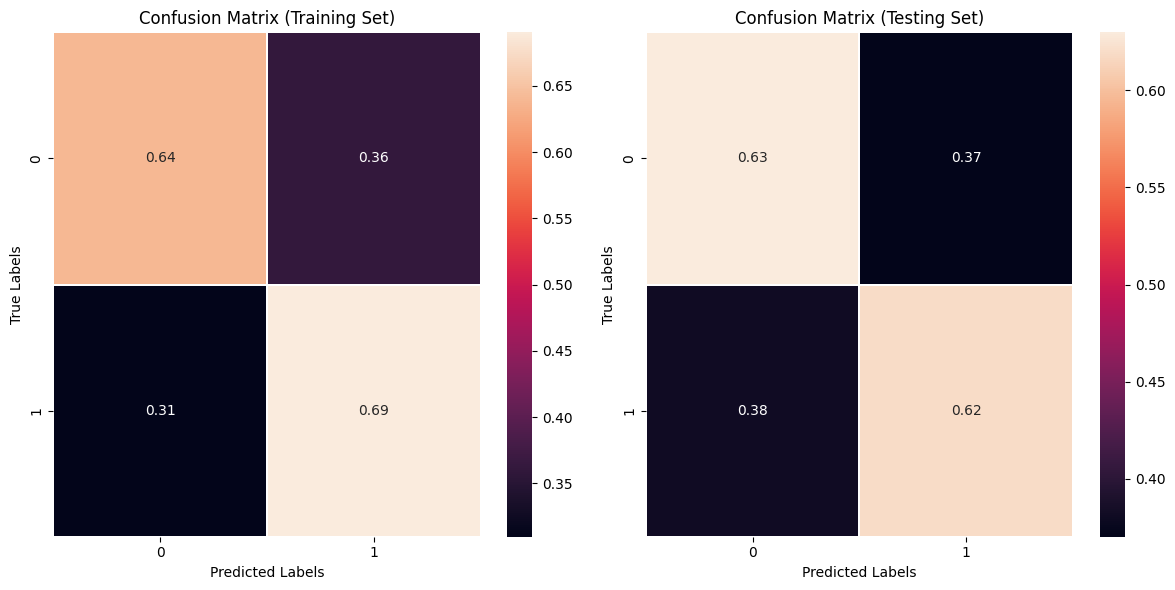

Training Set Metrics:
Accuracy: 0.6643401015228426
F1 Score: 0.6728509585652444
Precision: 0.6562123039806996
Recall: 0.6903553299492385

Testing Set Metrics:
Accuracy: 0.6256410256410256
F1 Score: 0.5680473372781066
Precision: 0.5245901639344263
Recall: 0.6193548387096774


In [ ]:
# Create a logistic regression classifier
logreg = LogisticRegression(C=1.0, max_iter=10000)

# Fit the logistic regression model
logreg.fit(X_train, y_train)

pred_train = logreg.predict(X_train) 
pred_test = logreg.predict(X_test) 

with open('models/LR_C1.0.pkl', 'wb') as file: pickle.dump(logreg,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

### Linear Discriminant Analysis

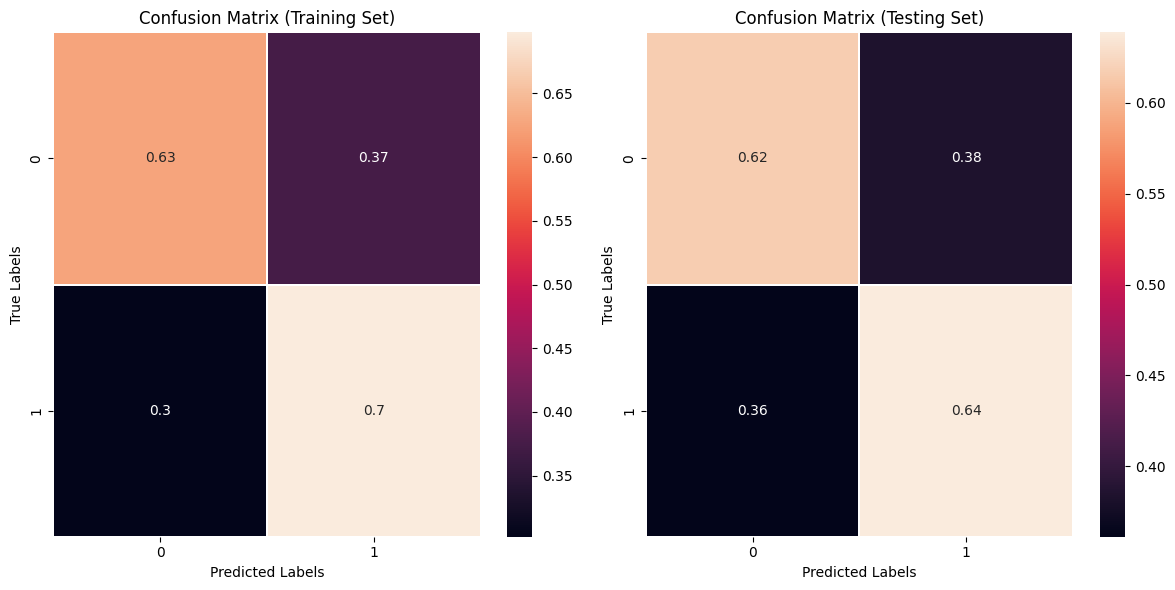

Training Set Metrics:
Accuracy: 0.6618020304568528
F1 Score: 0.6736068585425597
Precision: 0.650887573964497
Recall: 0.6979695431472082

Testing Set Metrics:
Accuracy: 0.6256410256410256
F1 Score: 0.5755813953488372
Precision: 0.5238095238095238
Recall: 0.6387096774193548


In [ ]:
# Create the model
model = LinearDiscriminantAnalysis()

# Fit the model
model.fit(X_train, y_train)

pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 

with open('models/LDA.pkl', 'wb') as file: pickle.dump(model,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

### SVC

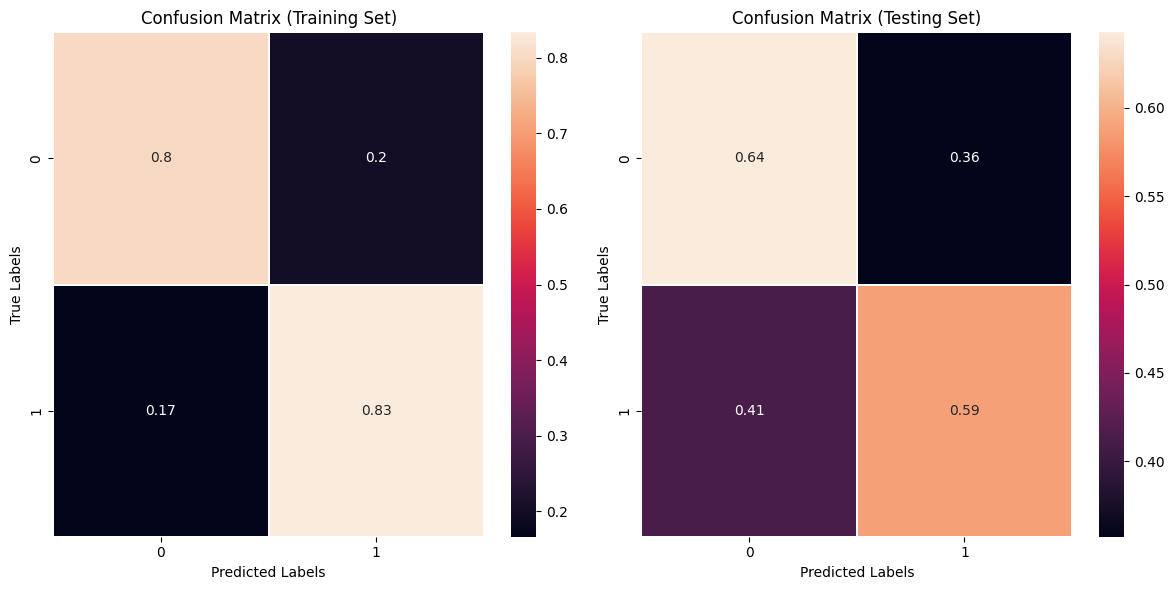

Training Set Metrics:
Accuracy: 0.8178934010152284
F1 Score: 0.820737039350406
Precision: 0.8081180811808119
Recall: 0.833756345177665

Testing Set Metrics:
Accuracy: 0.6205128205128205
F1 Score: 0.5515151515151515
Precision: 0.52
Recall: 0.5870967741935483


In [ ]:
# Create the model
model = SVC(C=1.099, kernel='rbf', probability=True)

# Fit the model
model.fit(X_train, y_train)

pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 

with open('models/SVC_rbf_C1.099.pkl', 'wb') as file: pickle.dump(model,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

### MLP Classifier

In [ ]:
best_models.loc[0, 'MLPClassifier']

'MLPClassifier(alpha=1.9286681792194078, hidden_layer_sizes=(40, 65, 20, 16, 12),\n              max_iter=3685)'

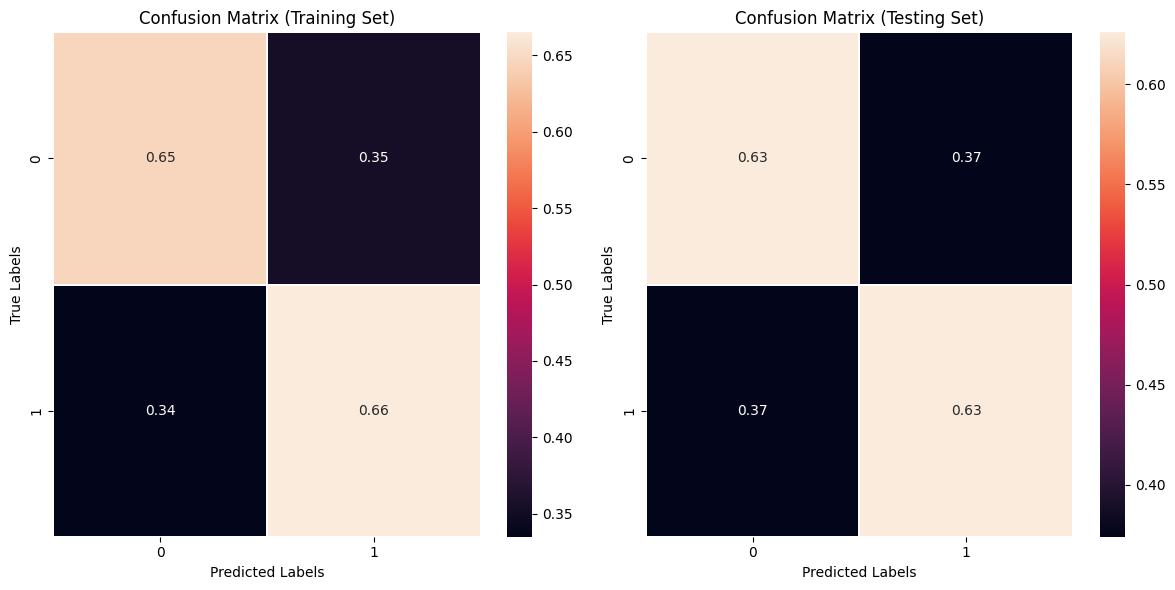

Training Set Metrics:
Accuracy: 0.6554568527918782
F1 Score: 0.6587052168447517
Precision: 0.6525529265255293
Recall: 0.6649746192893401

Testing Set Metrics:
Accuracy: 0.6256410256410256
F1 Score: 0.5705882352941176
Precision: 0.5243243243243243
Recall: 0.6258064516129033


In [ ]:
# Create the model
alpha=6.8
hidden_sizes=(10, 5)
model = MLPClassifier(alpha=alpha, hidden_layer_sizes=hidden_sizes, max_iter=10000)

# Fit the model
model.fit(X_train, y_train)

pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 

with open(f'models/MLP_alpha_{alpha}_hidden_10_5.pkl', 'wb') as file: pickle.dump(model,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

### Random Forest

In [ ]:
best_models.loc[0, 'RandomForestClassifier']

'RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=20,\n                       n_estimators=650)'

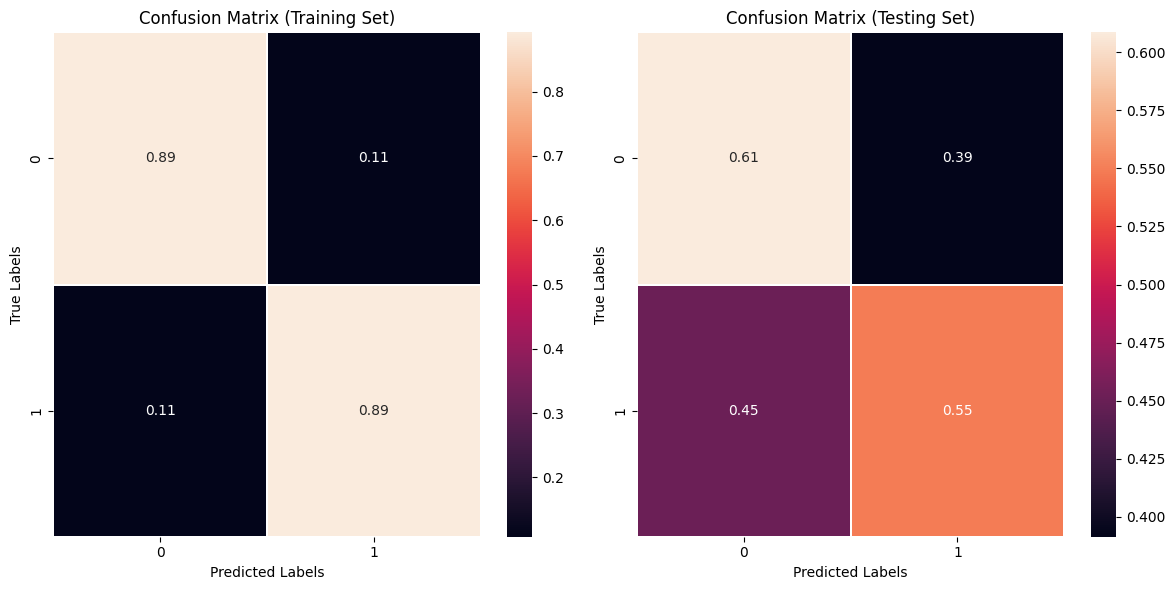

Training Set Metrics:
Accuracy: 0.891497461928934
F1 Score: 0.8914285714285715
Precision: 0.8919949174078781
Recall: 0.8908629441624365

Testing Set Metrics:
Accuracy: 0.5846153846153846
F1 Score: 0.5120481927710844
Precision: 0.480225988700565
Recall: 0.5483870967741935


In [ ]:
# Create the model
model = RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=20)

# Fit the model
model.fit(X_train, y_train)

pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 

with open(f'models/RandomForest_max_depth_8_msl_8_mss_20.pkl', 'wb') as file: pickle.dump(model,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

# Ensemble

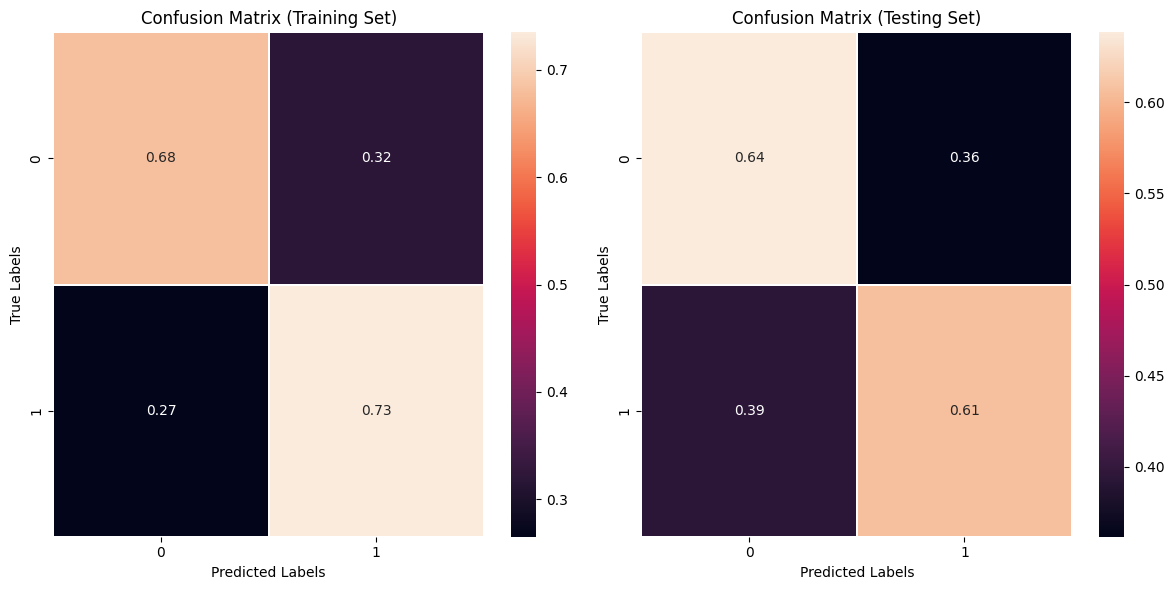

Training Set Metrics:
Accuracy: 0.7074873096446701
F1 Score: 0.7152563310685608
Precision: 0.6967509025270758
Recall: 0.7347715736040609

Testing Set Metrics:
Accuracy: 0.6256410256410256
F1 Score: 0.562874251497006
Precision: 0.5251396648044693
Recall: 0.6064516129032258


In [ ]:
# HARD ENSEMBLE
model1 = LogisticRegression(C=1.0, max_iter=10000)
model2 = SVC(C=1.099, kernel='rbf', probability=True)
model3 = MLPClassifier(alpha=alpha, hidden_layer_sizes=hidden_sizes, max_iter=10000)

ensemble = VotingClassifier( 
    estimators=[('cfr1', model1),('clf2', model2),('clf3', model3)],
    voting= 'hard', 
    ) 

ensemble.fit(X_train,y_train) 

pred_train = ensemble.predict(X_train) 
pred_test = ensemble.predict(X_test) 

with open(f'models/ensemble_hard.pkl', 'wb') as file: pickle.dump(ensemble,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

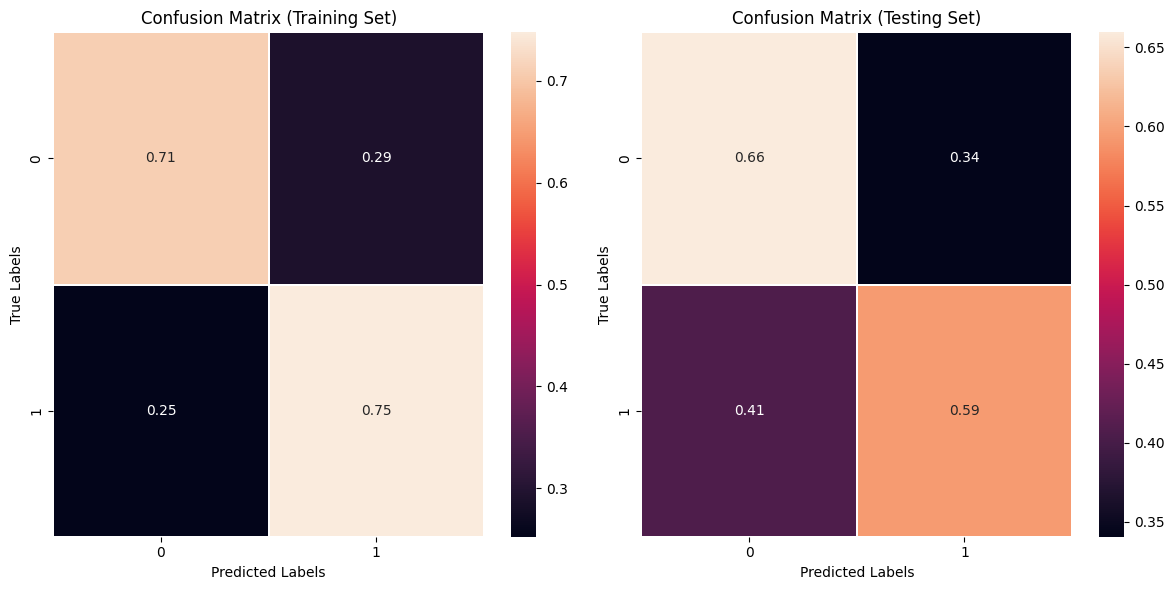

Training Set Metrics:
Accuracy: 0.7290609137055838
F1 Score: 0.7339563862928349
Precision: 0.7209302325581395
Recall: 0.7474619289340102

Testing Set Metrics:
Accuracy: 0.6333333333333333
F1 Score: 0.5626911314984709
Precision: 0.5348837209302325
Recall: 0.5935483870967742


In [ ]:
# SOFT ENSEMBLE
model1 = LogisticRegression(C=1.0, max_iter=10000)
model2 = SVC(C=1.099, kernel='rbf', probability=True)
model3 = MLPClassifier(alpha=alpha, hidden_layer_sizes=hidden_sizes, max_iter=10000)

ensemble = VotingClassifier( 
    estimators=[('cfr1', model1),('clf2', model2),('clf3', model3)],
    voting= 'soft', 
    ) 

ensemble.fit(X_train,y_train) 

pred_train = ensemble.predict(X_train) 
pred_test = ensemble.predict(X_test) 

with open(f'models/ensemble_soft.pkl', 'wb') as file: pickle.dump(ensemble,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

# MRMR

In [52]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train = y_train.copy() 
y_test = y_test.copy() 

In [21]:
X_train_copy.shape 

(1576, 43)

In [22]:
def hyperp_search_mrmr(classifier, parameters): #definition of a function used to GridSearch and metrics
    cv = StratifiedKFold(n_splits=10) 
    gs = GridSearchCV(classifier, parameters, cv=cv, scoring = 'accuracy', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train_mrmr, y_train) 
    best_index = gs.best_index_ 
    best_std = gs.cv_results_['std_test_score'][best_index]    
    val_acc = gs.cv_results_['mean_test_score'][best_index] 
    best_model = gs.best_estimator_ 
    best_model.fit(X_train_mrmr, y_train) 
    y_pred = best_model.predict(X_test_mrmr) 
    y_pred_train = best_model.predict(X_train_mrmr) 
    return accuracy_score(y_train, y_pred_train), val_acc, accuracy_score(y_test, y_pred), best_model, best_std
acc_mrmr = {} 

In [23]:
y = pd.Series(y_train).reset_index(drop=True) 

massimo_mrmr = 0
k_opt_mrmr = 0 
history_mrmr = []
sum_history_mrmr = [] 
test_max_mrmr = {} 
sum_max_mrmr = {}
acc_mrmr = {} 
somma_mrmr = 0

massimo_lda = 0
k_opt_lda = 0 
history_lda = []
sum_history_lda = [] 
test_max_lda = {} 
sum_max_lda = {}
acc_mrmr_lda = {} 
somma_lda = 0

for k in range(1,round(len(X_train_copy.columns)),1): 

    mrmr_features = mrmr_classif(X=X_train_copy, y=y, K=k)
    
    X_train_mrmr = X_train_copy[mrmr_features]  
    X_test_mrmr = X_test_copy[mrmr_features] 
    
    ############################################################################################
    ############################################ MRMR ##########################################
    ############################################################################################

    classifier1 = LogisticRegression() 
    parameters1 = {"C":[1e-4,0.01,0.1,1,3], "max_iter":[1000,1050,1200,900] }
    acc_mrmr['LogisticRegression'] = hyperp_search_mrmr(classifier1,parameters1) 

    classifier2 = GaussianNB() 
    parameters2 = {} 
    acc_mrmr['GaussianNB'] = hyperp_search_mrmr(classifier2,parameters2) 

    classifier3 = DecisionTreeClassifier() 
    parameters3 = {'criterion': ['entropy','gini'], 
                  'max_depth': [4,5,6,8,7], 
                  'min_samples_split': [5,10,20,8], 
                  'min_samples_leaf': [10,20,14,8]} 
    acc_mrmr['DecisionTreeClassifier'] = hyperp_search_mrmr(classifier3,parameters3)

    classifier4= LinearDiscriminantAnalysis() 
    parameters4 = {} 
    acc_mrmr['LinearDiscriminantAnalysis'] = hyperp_search_mrmr(classifier4,parameters4)  

    classifier5= QuadraticDiscriminantAnalysis() 
    parameters5 = {} 
    acc_mrmr['QuadraticDiscriminantAnalysis'] = hyperp_search_mrmr(classifier5,parameters5)

    classifier6 = SVC(probability=True) 
    parameters6 = {"kernel":['linear','rbf','poly','sigmoid'], "C":[0.01,1,2,0.1]}
    #acc_mrmr['SVC'] = hyperp_search_mrmr(classifier6,parameters6)

    classifier10 = KNeighborsClassifier() 
    parameters10 = {'n_neighbors':np.arange(10,200,4)} 
    acc_mrmr['Knn'] = hyperp_search_mrmr(classifier10,parameters10)
    
    res_mrmr = pd.DataFrame(acc_mrmr) 
    res_mrmr.index = ['Accuracy Train','Accuracy val', 'Accuracy Test','Parameters','Std']
    
    max_temp_mrmr = max(res_mrmr.loc['Accuracy val']) 
    max_test = max(res_mrmr.loc['Accuracy Test']) 
    somma_temp_mrmr =  sum(res_mrmr.loc['Accuracy val'])/7
    test_max_mrmr[k] = max_temp_mrmr 
    sum_max_mrmr[k] = somma_temp_mrmr
    
    if  somma_temp_mrmr > somma_mrmr and max_temp_mrmr == massimo_mrmr:
        
        massimo_mrmr = max_temp_mrmr
        somma_mrmr = somma_temp_mrmr
        k_opt_mrmr = k 
        best_res_mrmr = res_mrmr.copy() 
        features_mrmr = mrmr_features
        
    if  max_temp_mrmr > massimo_mrmr:
        
        massimo_mrmr = max_temp_mrmr
        somma_mrmr = somma_temp_mrmr 
        k_opt_mrmr = k 
        best_res_mrmr = res_mrmr.copy() 
        features_mrmr = mrmr_features 
    

    print('acc val mrmr=',max_temp_mrmr) 
    print('avg acc mrmr=',somma_temp_mrmr) 
    print('acc test = ',max_test)
    history_mrmr.append(max_temp_mrmr) 
    sum_history_mrmr.append(somma_temp_mrmr)
    feature_mrmr = mrmr_features 
    print(k*100/round(len(X_train_copy.columns)),'%') 

100%|██████████| 1/1 [00:00<00:00, 422.56it/s]


acc val mrmr= 0.552084173183907
avg acc mrmr= 0.46577440941707643
acc test =  0.6025641025641025
2.3255813953488373 %


100%|██████████| 2/2 [00:00<00:00, 56.14it/s]


acc val mrmr= 0.577501410948964
avg acc mrmr= 0.4859216088273574
acc test =  0.6025641025641025
4.651162790697675 %


100%|██████████| 3/3 [00:00<00:00, 42.25it/s]


acc val mrmr= 0.6085664758526164
avg acc mrmr= 0.5102020248557376
acc test =  0.6435897435897436
6.976744186046512 %


100%|██████████| 4/4 [00:00<00:00, 36.02it/s]


acc val mrmr= 0.6136539546883818
avg acc mrmr= 0.5126616832333192
acc test =  0.6564102564102564
9.30232558139535 %


100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


acc val mrmr= 0.6155446263000887
avg acc mrmr= 0.5141947224749772
acc test =  0.6410256410256411
11.627906976744185 %


100%|██████████| 6/6 [00:00<00:00, 31.46it/s]


acc val mrmr= 0.6187132145448682
avg acc mrmr= 0.5194578500593174
acc test =  0.6358974358974359
13.953488372093023 %


100%|██████████| 7/7 [00:00<00:00, 41.68it/s]


acc val mrmr= 0.6162097879545272
avg acc mrmr= 0.5182018175326245
acc test =  0.617948717948718
16.27906976744186 %


100%|██████████| 8/8 [00:00<00:00, 24.57it/s]


acc val mrmr= 0.626312182536483
avg acc mrmr= 0.5236331071975674
acc test =  0.6256410256410256
18.6046511627907 %


100%|██████████| 9/9 [00:00<00:00, 41.21it/s]


acc val mrmr= 0.6333387083770056
avg acc mrmr= 0.5245309314566752
acc test =  0.6512820512820513
20.930232558139537 %


100%|██████████| 10/10 [00:00<00:00, 40.77it/s]


acc val mrmr= 0.6320769168749496
avg acc mrmr= 0.5242712016677993
acc test =  0.6512820512820513
23.25581395348837 %


100%|██████████| 11/11 [00:00<00:00, 39.80it/s]


acc val mrmr= 0.6301539950012094
avg acc mrmr= 0.526445790764907
acc test =  0.6410256410256411
25.58139534883721 %


100%|██████████| 12/12 [00:00<00:00, 24.60it/s]


acc val mrmr= 0.6320769168749496
avg acc mrmr= 0.5281850013245643
acc test =  0.658974358974359
27.906976744186046 %


100%|██████████| 13/13 [00:00<00:00, 39.78it/s]


acc val mrmr= 0.6308110940901395
avg acc mrmr= 0.524092673431543
acc test =  0.6564102564102564
30.232558139534884 %


100%|██████████| 14/14 [00:00<00:00, 40.58it/s]


acc val mrmr= 0.629537208739821
avg acc mrmr= 0.5232599255940383
acc test =  0.6615384615384615
32.55813953488372 %


100%|██████████| 15/15 [00:00<00:00, 39.12it/s]


acc val mrmr= 0.6307990002418771
avg acc mrmr= 0.5224484859653771
acc test =  0.6717948717948717
34.883720930232556 %


100%|██████████| 16/16 [00:00<00:00, 25.98it/s]


acc val mrmr= 0.6403047649762155
avg acc mrmr= 0.5251672982342981
acc test =  0.6846153846153846
37.2093023255814 %


100%|██████████| 17/17 [00:00<00:00, 41.13it/s]


acc val mrmr= 0.6390308796258969
avg acc mrmr= 0.526534478985499
acc test =  0.6846153846153846
39.53488372093023 %


100%|██████████| 18/18 [00:00<00:00, 39.02it/s]


acc val mrmr= 0.6339595259211481
avg acc mrmr= 0.5243604657859274
acc test =  0.6512820512820513
41.86046511627907 %


100%|██████████| 19/19 [00:00<00:00, 39.44it/s]


acc val mrmr= 0.6390671611706845
avg acc mrmr= 0.5253688623720068
acc test =  0.6564102564102564
44.18604651162791 %


100%|██████████| 20/20 [00:00<00:00, 39.77it/s]


acc val mrmr= 0.6390711924534387
avg acc mrmr= 0.5271731493532671
acc test =  0.6615384615384615
46.51162790697674 %


100%|██████████| 21/21 [00:00<00:00, 41.36it/s]


acc val mrmr= 0.6447714262678385
avg acc mrmr= 0.5311658469725067
acc test =  0.6410256410256411
48.83720930232558 %


100%|██████████| 22/22 [00:00<00:00, 41.36it/s]


acc val mrmr= 0.6473111344029671
avg acc mrmr= 0.5312441690374449
acc test =  0.6435897435897436
51.16279069767442 %


100%|██████████| 23/23 [00:00<00:00, 41.03it/s]


acc val mrmr= 0.6460211239216318
avg acc mrmr= 0.5280755807926653
acc test =  0.6512820512820513
53.48837209302326 %


100%|██████████| 24/24 [00:00<00:00, 25.79it/s]


acc val mrmr= 0.6472990405547044
avg acc mrmr= 0.5289837712074268
acc test =  0.6538461538461539
55.81395348837209 %


100%|██████████| 25/25 [00:00<00:00, 40.73it/s]


acc val mrmr= 0.6428565669596066
avg acc mrmr= 0.5276102555833267
acc test =  0.658974358974359
58.13953488372093 %


100%|██████████| 26/26 [00:00<00:00, 40.49it/s]


acc val mrmr= 0.6422115617189389
avg acc mrmr= 0.5273505257944506
acc test =  0.6538461538461539
60.46511627906977 %


100%|██████████| 27/27 [00:00<00:00, 41.83it/s]


acc val mrmr= 0.6409538014996372
avg acc mrmr= 0.5280761566902017
acc test =  0.6564102564102564
62.7906976744186 %


100%|██████████| 28/28 [00:02<00:00, 11.93it/s]


acc val mrmr= 0.6415947754575506
avg acc mrmr= 0.5269030534087376
acc test =  0.6538461538461539
65.11627906976744 %


100%|██████████| 29/29 [00:00<00:00, 42.29it/s]


acc val mrmr= 0.6384140933645086
avg acc mrmr= 0.5273539811796685
acc test =  0.6538461538461539
67.44186046511628 %


100%|██████████| 30/30 [00:01<00:00, 18.51it/s]


acc val mrmr= 0.6377892445376119
avg acc mrmr= 0.5269715852155584
acc test =  0.6538461538461539
69.76744186046511 %


100%|██████████| 31/31 [00:00<00:00, 41.39it/s]


acc val mrmr= 0.6352374425542208
avg acc mrmr= 0.5273464945116965
acc test =  0.6487179487179487
72.09302325581395 %


100%|██████████| 32/32 [00:00<00:00, 42.87it/s]


acc val mrmr= 0.6377690881238409
avg acc mrmr= 0.5270804298499211
acc test =  0.6358974358974359
74.4186046511628 %


100%|██████████| 33/33 [00:00<00:00, 34.31it/s]


acc val mrmr= 0.6314077239377569
avg acc mrmr= 0.5242648667948998
acc test =  0.6358974358974359
76.74418604651163 %


100%|██████████| 34/34 [00:00<00:00, 43.48it/s]


acc val mrmr= 0.637744900427316
avg acc mrmr= 0.5254258762281016
acc test =  0.6461538461538462
79.06976744186046 %


100%|██████████| 35/35 [00:00<00:00, 44.32it/s]


acc val mrmr= 0.6358381036845924
avg acc mrmr= 0.5237039425945336
acc test =  0.6512820512820513
81.3953488372093 %


100%|██████████| 36/36 [00:00<00:00, 43.12it/s]


acc val mrmr= 0.6346287188583406
avg acc mrmr= 0.5231781481438823
acc test =  0.6333333333333333
83.72093023255815 %


100%|██████████| 37/37 [00:01<00:00, 27.48it/s]


acc val mrmr= 0.6333669273562847
avg acc mrmr= 0.5268926872530839
acc test =  0.6410256410256411
86.04651162790698 %


100%|██████████| 38/38 [00:00<00:00, 43.97it/s]


acc val mrmr= 0.634632750141095
avg acc mrmr= 0.5256280162633464
acc test =  0.6307692307692307
88.37209302325581 %


100%|██████████| 39/39 [00:00<00:00, 45.21it/s]


acc val mrmr= 0.6358824477948883
avg acc mrmr= 0.5242700498727266
acc test =  0.6384615384615384
90.69767441860465 %


100%|██████████| 40/40 [00:00<00:00, 45.86it/s]


acc val mrmr= 0.6333669273562847
avg acc mrmr= 0.5224502136579859
acc test =  0.6307692307692307
93.02325581395348 %


100%|██████████| 41/41 [00:00<00:00, 44.97it/s]


acc val mrmr= 0.6339998387486898
avg acc mrmr= 0.5233520691998479
acc test =  0.6333333333333333
95.34883720930233 %


100%|██████████| 42/42 [00:00<00:00, 46.70it/s]


acc val mrmr= 0.6352253487059583
avg acc mrmr= 0.5251701777219797
acc test =  0.6230769230769231
97.67441860465117 %


In [24]:
print('The best accuracy on mrmr val set is:', massimo_mrmr, ', the optimal k is', k_opt_mrmr) 
print('The average acc is:', somma_mrmr) 

The best accuracy on mrmr val set is: 0.6473111344029671 , the optimal k is 22
The average acc is: 0.5312441690374449


In [25]:
best_res_mrmr 

,LogisticRegression,GaussianNB,DecisionTreeClassifier,LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,Knn
Accuracy Train,0.659264,0.596447,0.708122,0.661168,0.63198,0.623731
Accuracy val,0.647311,0.592695,0.618721,0.646045,0.597158,0.616778
Accuracy Test,0.638462,0.576923,0.569231,0.64359,0.548718,0.571795
Parameters,"LogisticRegression(C=1, max_iter=1000)",GaussianNB(),"DecisionTreeClassifier(criterion='entropy', ma...",LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),KNeighborsClassifier(n_neighbors=130)
Std,0.047086,0.041002,0.047717,0.046851,0.040919,0.039815


In [53]:
k = k_opt_mrmr
X_train = X_train_copy[features_mrmr]  
X_test = X_test_copy[features_mrmr] 
best_res = best_res_mrmr
var = features_mrmr 

In [36]:
features_mrmr

['type.of.heart.failure_Left',
 'NYHA.cardiac.function.classification',
 'dischargeDay',
 'occupation_farmer',
 'log.D.dimer',
 'Hydrochlorothiazide tablet',
 'basophil.count',
 'moderate.to.severe.chronic.kidney.disease',
 'systolic.blood.pressure',
 'cholesterol',
 'uric.acid',
 'log.eosinophil.count',
 'Inotropes',
 'CCI.score',
 'basophil.ratio',
 'sodium',
 'glomerular.filtration.rate',
 'Furosemide tablet',
 'prothrombin.activity',
 'Furosemide injection',
 'red.blood.cell',
 'Digoxin tablet']

In [47]:
X_train.shape

(1576, 22)

In [54]:
X_train.to_csv('Data/mrmr_train.csv') 
X_test.to_csv('Data/mrmr_test.csv')   
pd.DataFrame(y_train).to_csv('Data/mrmr_y_train.csv') 
pd.DataFrame(y_test).to_csv('Data/mrmr_y_test.csv')   

In [27]:
def hyperp_search_smote(classifier, parameters): #definition of a function used to GridSearch and metrics
    cv = StratifiedKFold(n_splits=10)
    gs = GridSearchCV(classifier, parameters, cv=cv, scoring = 'accuracy', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train) 
    best_index = gs.best_index_ 
    best_std = gs.cv_results_['std_test_score'][best_index]  
    val_accuracy = gs.cv_results_['mean_test_score'][best_index]
    best_model = gs.best_estimator_ 
    best_model.fit(X_train,y_train) 
    y_pred = best_model.predict(X_test) 
    y_pred_train = best_model.predict(X_train) 
    
    return accuracy_score(y_train, y_pred_train),val_accuracy, accuracy_score(y_test, y_pred), best_model, best_std

In [28]:
#SVC
acc_mrmr = {}
classifier6 = SVC(probability=True) 
parameters6 = {"kernel":['linear','rbf','sigmoid','poly'], "C":[0.01,1,2,0.1]}
acc_mrmr['SVC'] = hyperp_search_smote(classifier6,parameters6)

#RandomForest 
classifier7= RandomForestClassifier() 
parameters7 = {'n_estimators' : [10,20,50,30,100], 
    'criterion' : ['entropy', 'gini'], 
              'max_depth': [4,5,6,8,7], 
              'min_samples_split': [5,10,20,8], 
              'min_samples_leaf': [10,20,14,8]} 
acc_mrmr['RandomForestClassifier'] = hyperp_search_smote(classifier7,parameters7) 

#MLP 
classifier8 = MLPClassifier() 
parameters8 = {"hidden_layer_sizes":[(10, 5),(15,5),(20,12,4)],  
                "max_iter": [3500,4000], "alpha": [0.1,0.5,0.8]} 
acc_mrmr['MLPClassifier'] = hyperp_search_smote(classifier8,parameters8) 

#AdaBoost 
classifier9 = AdaBoostClassifier() 
parameters9 = {'n_estimators' : [10,20,50,30,100]} 
acc_mrmr['AdaBoostClassifier'] = hyperp_search_smote(classifier9,parameters9)  


In [29]:
#Visualize results in a df
res_mrmr = pd.DataFrame(acc_mrmr) 
res_mrmr.index = ['Accuracy Train','Mean Accuracy Validation', 'Accuracy Test','Parameters','Std over validation'] 
res_mrmr = pd.concat([res_mrmr,best_res_mrmr], axis=1)

In [30]:
best_models = res_mrmr.sort_values(by=['Accuracy Test'], axis = 1)   #reorder df according to accuracy in ascending order
best_models_ = best_models.loc['Parameters'][-3:]                #takes top3 parameters
best_models_

LogisticRegression            LogisticRegression(C=1, max_iter=1000)
LinearDiscriminantAnalysis              LinearDiscriminantAnalysis()
SVC                                       SVC(C=1, probability=True)
Name: Parameters, dtype: object

In [31]:
best_models.to_csv('Hyperparameters/mrmr_hyper_search.csv')

In [38]:
best_models['MLPClassifier']['Parameters']

MLPClassifier(alpha=0.8, hidden_layer_sizes=(10, 5), max_iter=3500)

# Ensemble MRMR


In [55]:
# Loading data
X_train = pd.read_csv('Data/mrmr_train.csv').drop(['Unnamed: 0'], axis=1)
X_test = pd.read_csv('Data/mrmr_test.csv').drop(['Unnamed: 0'], axis=1)

y_train = pd.read_csv('Data/mrmr_y_train.csv').drop(['Unnamed: 0'], axis=1).values.flatten()
y_test = pd.read_csv('Data/mrmr_y_test.csv').drop(['Unnamed: 0'], axis=1).values.flatten()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.columns)
print((X_train.columns == X_test.columns).all())

(1576, 22)
(390, 22)
(1576,)
(390,)
Index(['type.of.heart.failure_Left', 'NYHA.cardiac.function.classification',
       'dischargeDay', 'occupation_farmer', 'log.D.dimer',
       'Hydrochlorothiazide tablet', 'basophil.count',
       'moderate.to.severe.chronic.kidney.disease', 'systolic.blood.pressure',
       'cholesterol', 'uric.acid', 'log.eosinophil.count', 'Inotropes',
       'CCI.score', 'basophil.ratio', 'sodium', 'glomerular.filtration.rate',
       'Furosemide tablet', 'prothrombin.activity', 'Furosemide injection',
       'red.blood.cell', 'Digoxin tablet'],
      dtype='object')
True


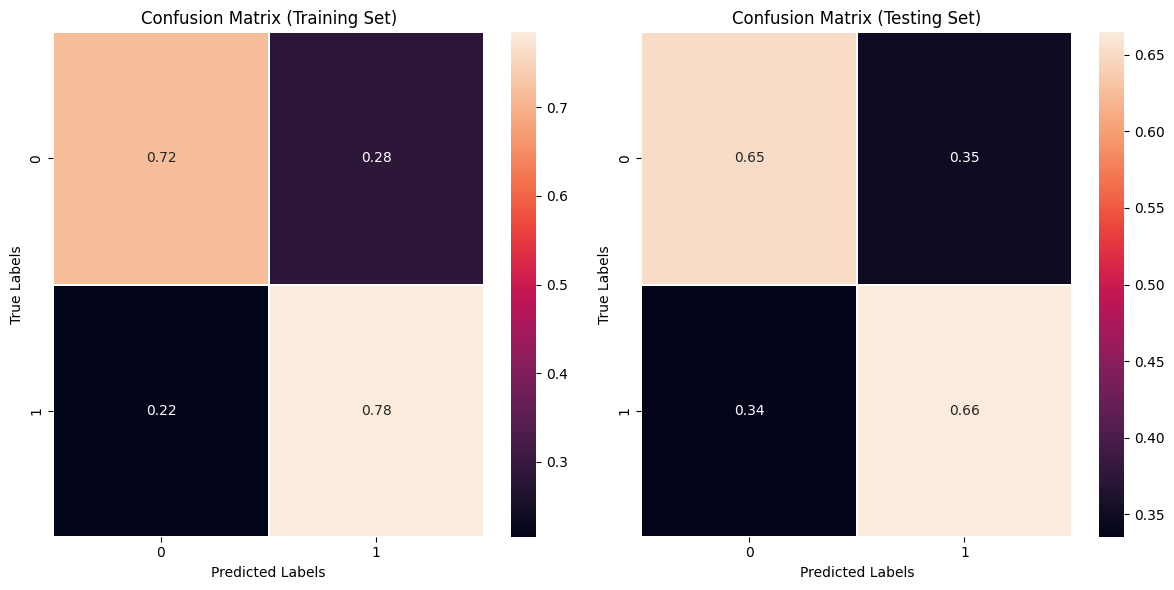

Training Set Metrics:
Accuracy: 0.75
F1 Score: 0.758282208588957
Precision: 0.7339667458432304
Recall: 0.7842639593908629

Testing Set Metrics:
Accuracy: 0.6564102564102564
F1 Score: 0.6058823529411763
Precision: 0.5567567567567567
Recall: 0.6645161290322581


In [61]:
# HARD ENSEMBLE
model1 = MLPClassifier(alpha=0.8, hidden_layer_sizes=(10, 5), max_iter=4000)
model2 = LinearDiscriminantAnalysis()
model3 = SVC(C=1, probability=True)

ensemble = VotingClassifier( 
    estimators=[('cfr1', model1),('clf2', model2),('clf3', model3)],
    voting= 'hard', 
    ) 

ensemble.fit(X_train,y_train) 

pred_train = ensemble.predict(X_train) 
pred_test = ensemble.predict(X_test) 

with open(f'models/ensemble_mrmr_hard.pkl', 'wb') as file: pickle.dump(ensemble,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 

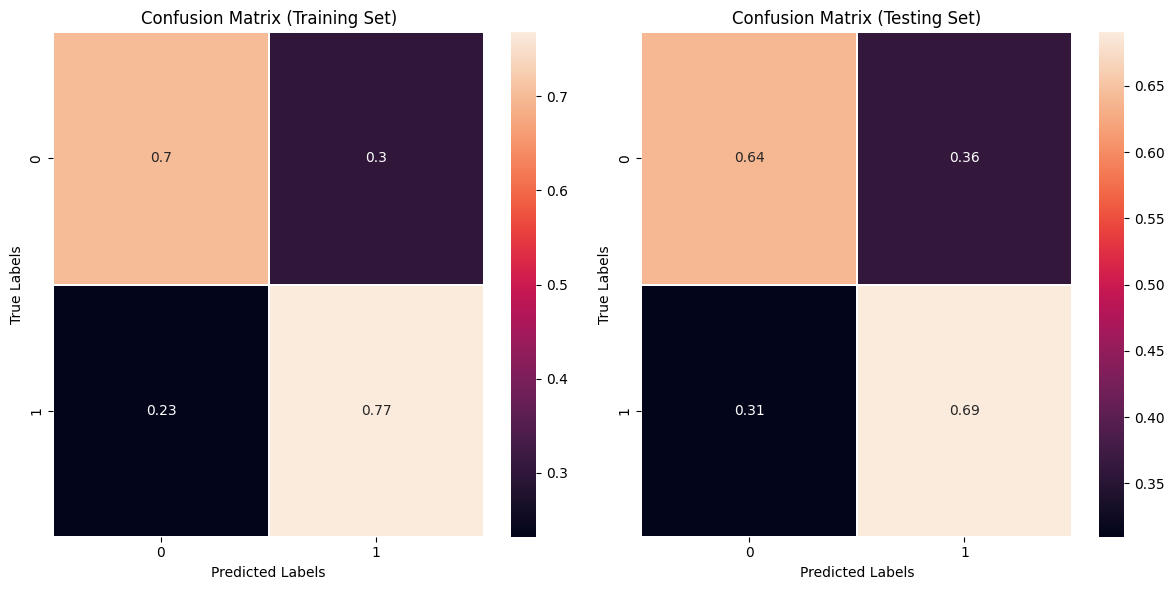

Training Set Metrics:
Accuracy: 0.7341370558375635
F1 Score: 0.7427869858809084
Precision: 0.7193816884661117
Recall: 0.7677664974619289

Testing Set Metrics:
Accuracy: 0.658974358974359
F1 Score: 0.6167146974063401
Precision: 0.5572916666666666
Recall: 0.6903225806451613


In [65]:
# HARD ENSEMBLE
model1 = MLPClassifier(alpha=0.8, hidden_layer_sizes=(10, 5), max_iter=10000)
model2 = LinearDiscriminantAnalysis()
model3 = SVC(C=1, probability=True)

ensemble = VotingClassifier( 
    estimators=[('cfr1', model1),('clf2', model2),('clf3', model3)],
    voting= 'soft', 
    ) 

ensemble.fit(X_train,y_train) 

pred_train = ensemble.predict(X_train) 
pred_test = ensemble.predict(X_test) 

with open(f'models/ensemble_mrmr_soft.pkl', 'wb') as file: pickle.dump(ensemble,file) 

compute_metrics(y_train,pred_train,y_test, pred_test) 